Objective:
In this assignment, you will work with an Activity Recognition dataset to explore, preprocess, and apply various classification algorithms. You will use different feature selection methods and dimensionality reduction techniques and compare the performance of classifiers under different scenarios, including the use of a Neural Network (NN).

**Part 1: Data Preprocessing**

**1.1 Load the Dataset**

* Load the Activity Recognition dataset into a pandas DataFrame.

* Display the first few rows.

* Check and handle any missing values.

**1.2 Train-Test Split**

* Split the dataset into training and testing sets using an 80/20 split.

In [1]:
#download csv from github
github = "https://raw.githubusercontent.com/scruz10FAU/DSACourse/main/Assignment4/Activity_data.csv" # Changed to raw content URL
!wget --no-cache --backups=1 {github}

--2025-04-14 23:12:54--  https://raw.githubusercontent.com/scruz10FAU/DSACourse/main/Assignment4/Activity_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4090382 (3.9M) [text/plain]
Failed to rename Activity_data.csv to Activity_data.csv.1: (2) No such file or directory
Saving to: ‘Activity_data.csv’

Activity_data.csv   100%[===================>]   3.90M  --.-KB/s    in 0.09s   

2025-04-14 23:12:54 (41.4 MB/s) - ‘Activity_data.csv’ saved [4090382/4090382]



In [2]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics.pairwise import rbf_kernel, polynomial_kernel, linear_kernel
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from numpy.linalg import pinv, solve
from sklearn.cluster import KMeans
from scipy.linalg import eigh
from sklearn.kernel_approximation import Nystroem
from sklearn.feature_selection import chi2, mutual_info_regression, SelectPercentile, SelectKBest, mutual_info_classif, SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.neural_network import MLPClassifier


In [3]:
"""
1.1 Load the Dataset
Load the Activity Recognition dataset into a pandas DataFrame.
Display the first few rows.
"""

#load the Activity_data.csv file
df = pd.read_csv("Activity_data.csv")

#Display the first few rows using head
df.head()

,Time,frontal_axis_Acceleration,vertical_axis+_Acceleration,lateral_axis_Acceleration,Antenna_ID_Sensor,RSSI,Phase,Frequency,Activity
0,0.00,-0.232160,0.215880,-1.18820,2,-48.5,2.74430,920.75,3
1,0.25,-0.056282,0.043636,-1.14260,2,-50.0,2.36540,921.75,3
2,0.50,0.143050,0.296270,-1.33640,3,-59.5,0.20709,922.25,3
3,0.75,0.318930,0.284780,-0.92593,2,-51.0,0.41571,923.25,3
4,1.05,0.412730,0.135500,-1.02860,2,-44.5,4.45470,920.25,3


In [4]:
print(df.shape)

(75128, 9)


In [5]:
"""
Check and handle any missing values.
"""

#Find the missing values in each column
missing = df.isnull().sum()
print(f"The number of missing values in each column are :\n{missing}")

The number of missing values in each column are :
Time                           0
frontal_axis_Acceleration      0
vertical_axis+_Acceleration    0
lateral_axis_Acceleration      0
Antenna_ID_Sensor              0
RSSI                           0
 Phase                         0
Frequency                      0
Activity                       0
dtype: int64


There was no missing data in any column, so nothing needs to be modified.

In [6]:
"""
1.2 Train-Test Split

* Split the dataset into training and testing sets using an 80/20 split.
"""

#Separate data and labels; use last column as labels
df_data = df.iloc[:,:-1].to_numpy()
df_labels = df.iloc[:,-1].to_numpy()

#Create testing and training data
X_train, X_test, y_train, y_test = train_test_split(df_data, df_labels, test_size=0.2, random_state=42)


**Part 2: Classification on the Entire Dataset**

Apply the following classifiers using scikit-learn:

* Support Vector Machine (SVM): Linear and Kernel (RBF, Polynomial)

* k-Nearest Neighbors (KNN): Try different values of k

* Naive Bayes: GaussianNB

* Linear Discriminant Analysis (LDA)

* Kernel Discriminant Analysis (KDA): RBF and Polynomial kernels

**Evaluation:**

* Evaluate all classifiers using:

 * Accuracy

 * Precision

 * Recall

 * F1-score

* Generate and visualize confusion matrices.

In [7]:
# Build KDA classifier
class KernelDiscriminantAnalysis(BaseEstimator, ClassifierMixin):
    def __init__(self, kernel='linear', degree=3, coef0=1, gamma=None, reg=1e-3):
        """
        Kernel Discriminant Analysis (KDA) Classifier with Linear, RBF, and Polynomial Kernels.

        Parameters:
        - kernel: Kernel type ('linear', 'rbf', or 'poly')
        - degree: Degree for polynomial kernel
        - coef0: Coefficient for polynomial kernel
        - gamma: Parameter for RBF kernel (default: 1/n_features)
        - reg: Regularization term to prevent singular matrix issues
        """
        self.kernel = kernel
        self.degree = degree
        self.coef0 = coef0
        self.gamma = gamma
        self.reg = reg
        self.eigenvectors = None
        self.class_means = None
        self.X_train = None
        self.y_train = None
        self.label_dict = {}

    def compute_kernel(self, X, Y=None):
        """Computes the kernel matrix."""
        if self.kernel == 'rbf':
            return rbf_kernel(X, Y, gamma=self.gamma)
        elif self.kernel == 'poly':
            return polynomial_kernel(X, Y, degree=self.degree, coef0=self.coef0)
        elif self.kernel == 'linear':
            return linear_kernel(X, Y)
        else:
            raise ValueError("Unsupported kernel. Choose from 'rbf', 'poly', or 'linear'.")

    def encode_labels(self, y):
        """Encodes categorical labels into numerical values manually."""
        unique_classes = np.unique(y)
        self.label_dict = {label: idx for idx, label in enumerate(unique_classes)}
        return np.array([self.label_dict[label] for label in y])

    def fit(self, X, y):
        """Fits the KDA model and computes the discriminant space."""
        self.X_train = X
        self.y_train = self.encode_labels(y)

        n_samples = X.shape[0]
        K = self.compute_kernel(X).astype(np.float32)

        classes = np.unique(self.y_train)
        N_c, K_c, mean_c = {}, {}, {}

        # Compute class-wise kernel matrices
        for c in classes:
            idx = np.where(self.y_train == c)[0]
            K_c[c] = K[:, idx]
            N_c[c] = len(idx)
            mean_c[c] = np.mean(K_c[c], axis=1, keepdims=True)

        # Compute between-class scatter matrix M
        mean_total = np.mean(K, axis=1, keepdims=True)
        M = np.zeros((n_samples, n_samples))
        for c in classes:
            diff = mean_c[c] - mean_total
            M += N_c[c] * (diff @ diff.T)

        # Compute within-class scatter matrix N
        N = np.zeros((n_samples, n_samples))
        for c in classes:
            N += K_c[c] @ (np.eye(N_c[c]) - (1 / N_c[c]) * np.ones((N_c[c], N_c[c]))) @ K_c[c].T

        # Regularize N to ensure positive definiteness
        N += np.eye(N.shape[0]) * self.reg

        # Solve the generalized eigenvalue problem using np.linalg.solve()
        try:
            #eigvals, eigvecs = np.linalg.eig(solve(N, M))  # Solve for eigenvectors
            eigvals, eigvecs = eigh(M, N)
        except np.linalg.LinAlgError:
            print("Warning: N is singular, using pseudo-inverse instead.")
            eigvals, eigvecs = np.linalg.eig(pinv(N) @ M)

        # Select top discriminant directions
        idx = np.argsort(-eigvals)
        self.eigenvectors = eigvecs[:, idx[:len(classes) - 1]]

        # Normalize eigenvectors
        self.eigenvectors /= np.linalg.norm(self.eigenvectors, axis=0)

        # Compute class means in the transformed space
        self.class_means = {}
        transformed_X = self.transform(X)
        for c in classes:
            self.class_means[c] = np.mean(transformed_X[self.y_train == c], axis=0)

    def transform(self, X):
        """Projects data onto the discriminant space."""
        K_test = self.compute_kernel(X, self.X_train)
        return K_test @ self.eigenvectors

    def predict(self, X):
        """Predicts class labels based on the nearest class mean."""
        X_proj = self.transform(X)
        predictions = []
        for x in X_proj:
            # Assign to nearest class mean
            distances = {c: np.linalg.norm(x - self.class_means[c]) for c in self.class_means}
            predictions.append(min(distances, key=distances.get))
        return np.array(predictions)

# Generate synthetic dataset
def generate_data(n_samples=200, n_features=5, n_classes=3):
    """Generates a synthetic classification dataset using NumPy."""
    np.random.seed(42)
    X = np.random.randn(n_samples, n_features)

    # Generate labels
    y = np.random.choice(np.arange(n_classes), size=n_samples)
    return X, y

In [8]:
#Kmeans clustering functions to reduce dataset size for easier processing in KDA

def compute_kernel(X1, X2, kernel='linear', **kwargs):
    if kernel == 'linear':
        return X1 @ X2.T
    elif kernel == 'poly':
        degree = kwargs.get('degree', 3)
        coef0 = kwargs.get('coef0', 1)
        return (X1 @ X2.T + coef0) ** degree
    elif kernel == 'rbf':
        gamma = kwargs.get('gamma', 0.5)
        X1_sq = np.sum(X1**2, axis=1).reshape(-1, 1)
        X2_sq = np.sum(X2**2, axis=1).reshape(1, -1)
        dist_sq = X1_sq - 2 * X1 @ X2.T + X2_sq
        return np.exp(-gamma * dist_sq)
    else:
        raise ValueError(f"Unknown kernel type: {kernel}")

def get_kernel_kmeans(K, n_clusters=5, max_iter=300):
  """
  get_kernel_kmeans(K, n_clusters=5, max_iter=300)
  function for kernel kmeans clustering
  K is a kernel
  """

  #set number of samples
  n_samples = K.shape[0]
  #set random clusters
  labels = np.random.randint(0, n_clusters, size=n_samples)

  #assign points to cluster using distances
  for _ in range(max_iter):
    #get distances
    distances = np.zeros((n_samples, n_clusters))
    for j in range(n_clusters):
      #mask labels that are the same as j
      cluster_indices = labels == j
      cluster_sum = np.sum(cluster_indices)
      #end iteration if sum is 0
      if cluster_sum == 0:
        continue

      #get distances from cluster
      K_ii = K.diagonal()
      K_ij = np.sum(K[:, cluster_indices], axis=1)/cluster_sum
      K_jj = np.sum(K[np.ix_(cluster_indices, cluster_indices)])/(cluster_sum**2)

      distances[:, j] = K_ii - 2*K_ij + K_jj
    #get the new labels
    new_labels = np.argmin(distances, axis=1)

    if np.all(new_labels == labels):
      break

    labels = new_labels

  return labels



In [9]:
"""
Apply the following classifiers using scikit-learn:
* Support Vector Machine (SVM): Linear and Kernel (RBF, Polynomial)
* k-Nearest Neighbors (KNN): Try different values of k
* Naive Bayes: GaussianNB
* Linear Discriminant Analysis (LDA)
* Kernel Discriminant Analysis (KDA): RBF and Polynomial kernels
"""

#create each classifier
svm = make_pipeline(StandardScaler(),SVC())
svm_rbf = make_pipeline(StandardScaler(), SVC(kernel='rbf'))
svm_poly = make_pipeline(StandardScaler(), SVC(kernel='poly'))
knn3 = make_pipeline(StandardScaler(),KNeighborsClassifier(n_neighbors=3))
knn5 = make_pipeline(StandardScaler(),KNeighborsClassifier(n_neighbors=5))
knn10 = make_pipeline(StandardScaler(),KNeighborsClassifier(n_neighbors=10))
naive_bayes = make_pipeline(StandardScaler(),GaussianNB())
lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis())

#custom KDA function uses too much RAM and crashes. Nystroem transformer was used with LDA to circumvent
#kda_rbf = make_pipeline(StandardScaler(), KMeans(n_clusters=10), KernelDiscriminantAnalysis(kernel='rbf'))
#kda_poly = make_pipeline(StandardScaler(), KMeans(n_clusters=10), KernelDiscriminantAnalysis(kernel='poly'))

rbf_transformer = Nystroem(kernel='rbf', gamma=0.1, n_components=500, random_state=42)
poly_transformer = Nystroem(kernel='poly', degree=3, coef0=1, n_components=500, random_state=42)

kda_rbf = make_pipeline(StandardScaler(), rbf_transformer, LinearDiscriminantAnalysis())
kda_poly = make_pipeline(StandardScaler(),  poly_transformer, LinearDiscriminantAnalysis())

In [10]:
#function to display confusion matrix

def display_confusion_matrix(matrix, labels):
  #convert class labels to list of labels
  class_labels = np.unique(labels).tolist()
  class_labels = [f"Activity {i}" for i in class_labels]

  plt.figure(figsize=(8, 6))
  plt.imshow(matrix, interpolation="nearest", cmap=plt.cm.Blues)

  #set ticks and labels
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted Labels")
  plt.ylabel("True Labels")
  tick = np.arange(len(class_labels))
  plt.xticks(tick, class_labels)
  plt.yticks(tick, class_labels)

  #annotate cells with count
  thresh = matrix.max() / 2.0
  for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
      plt.text(j, i, format(matrix[i, j], 'd'),
               horizontalalignment="center",
               color="white" if matrix[i, j] > thresh else "black")

  #display matrix
  plt.tight_layout()
  plt.show()


In [11]:
"""
Evaluate all classifiers using:
Accuracy, Precision, Recall, F1-score

Generate and visualize confusion matrices.
"""
#Create a function to eval each classifier & get confusion matrix
def eval_classifier(cls, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
  #choose classifier
  cls.fit(X_train, y_train)
  y_pred = cls.predict(X_test)

  #evaluate classifier
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred, average='weighted')
  recall = recall_score(y_test, y_pred, average='weighted')
  f1 = f1_score(y_test, y_pred, average='weighted')

  #display scores
  print(f"Accuracy: {accuracy}")
  print(f"Precision: {precision}")
  print(f"Recall: {recall}")
  print(f"F1-score: {f1}")

  #generate confusion matrix
  conf_matrix = confusion_matrix(y_test, y_pred)
  print("Confusion Matrix:")
  #print(conf_matrix)
  display_confusion_matrix(conf_matrix, y_test)

  return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

#dictionary to store results output
results_dict = {}

Accuracy: 0.9726474111539998
Precision: 0.9734980573368397
Recall: 0.9726474111539998
F1-score: 0.9697855834049989
Confusion Matrix:


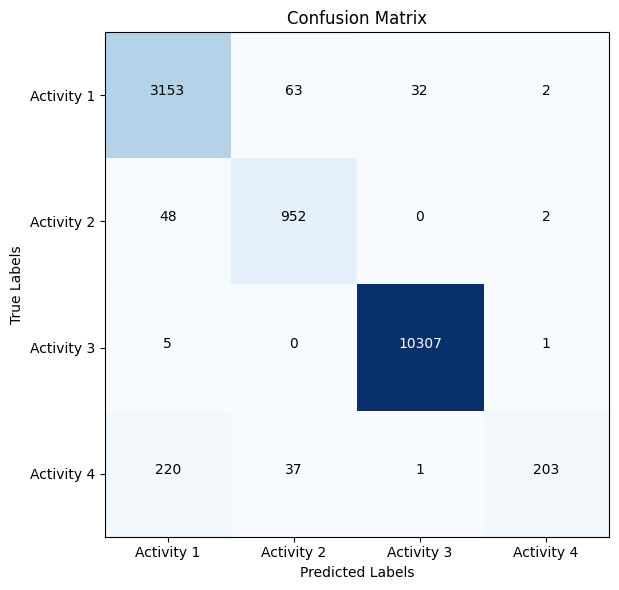

In [12]:
"""
Evaluate all classifiers using:
Accuracy, Precision, Recall, F1-score

Generate and visualize confusion matrices.
"""

#svm results
results_dict["SVM"] = eval_classifier(svm)

Activity 3 had the most true predictions. The other activities were also relatively accurate, however activity 4 was incorrectly predicted to be activity 1 220 times.

Accuracy: 0.9726474111539998
Precision: 0.9734980573368397
Recall: 0.9726474111539998
F1-score: 0.9697855834049989
Confusion Matrix:


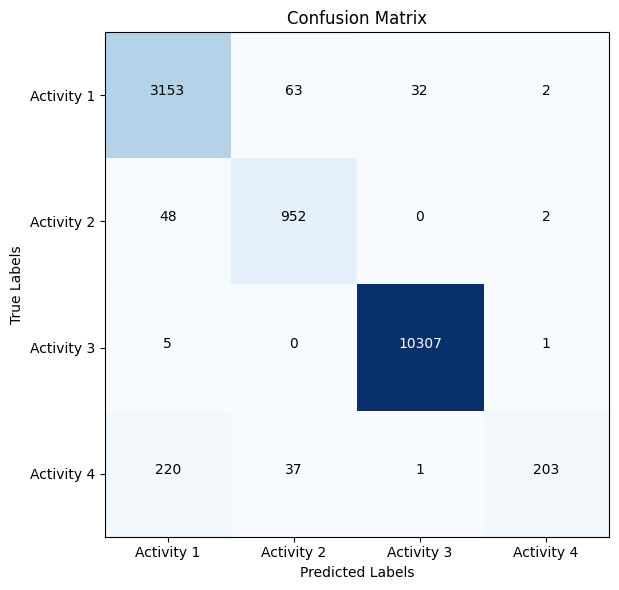

In [13]:
#svm results for rbf kernel
results_dict["RBF SVM"] = eval_classifier(svm_rbf)

SVM using RBF had similar results to linear SVM, with activity 4 being incorrectly predicted as activity 1 the same number of times as linear SVM.

Accuracy: 0.9716491414880873
Precision: 0.9720302615815423
Recall: 0.9716491414880873
F1-score: 0.9689344166262452
Confusion Matrix:


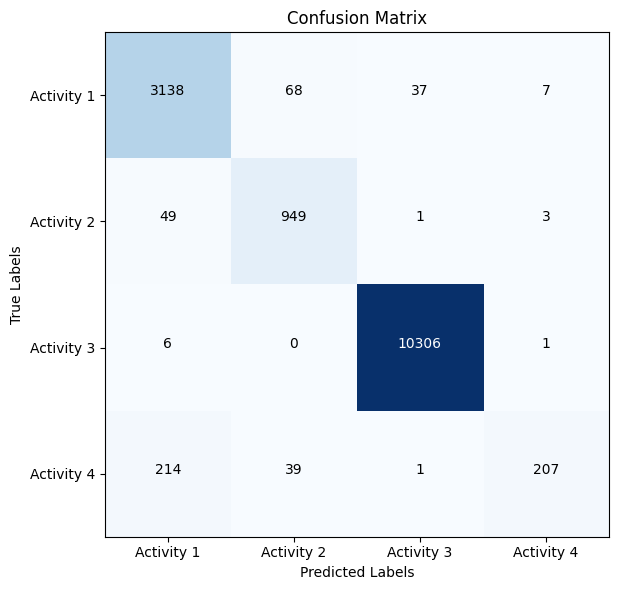

In [14]:
#svm results for poly kernel
results_dict["Poly SVM"] = eval_classifier(svm_poly)

Polynomial SVM had similar results, however there were more incorrect predictions than previously for activity 4.

Accuracy: 0.9842273392785837
Precision: 0.9840211576586365
Recall: 0.9842273392785837
F1-score: 0.983730922751593
Confusion Matrix:


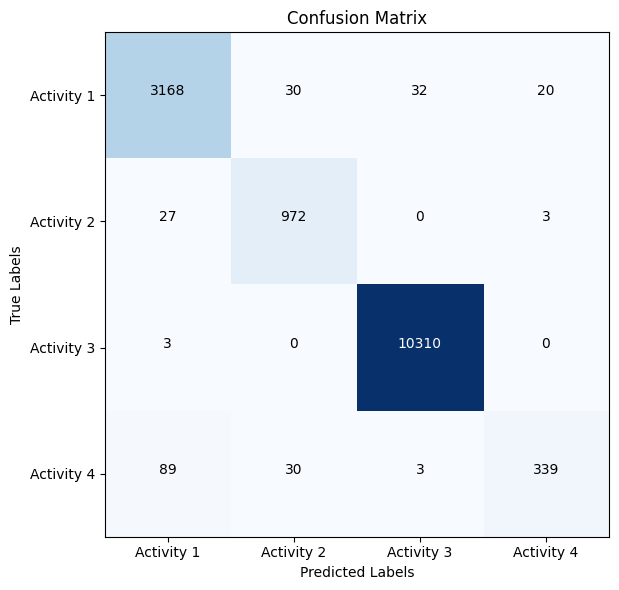

In [15]:
#knn3 reults
results_dict["KNN3"] = eval_classifier(knn3)

KNN with 3 neighbors was a better classifier than all SVM classifiers. It still had 89 incorrect predictions for activity 4 as activity 1, but it was much better than the SVM classifiers that had more incorrect classifications for activity 1 than correct ones.

Accuracy: 0.982230799946759
Precision: 0.9819545405321004
Recall: 0.982230799946759
F1-score: 0.9815652578445698
Confusion Matrix:


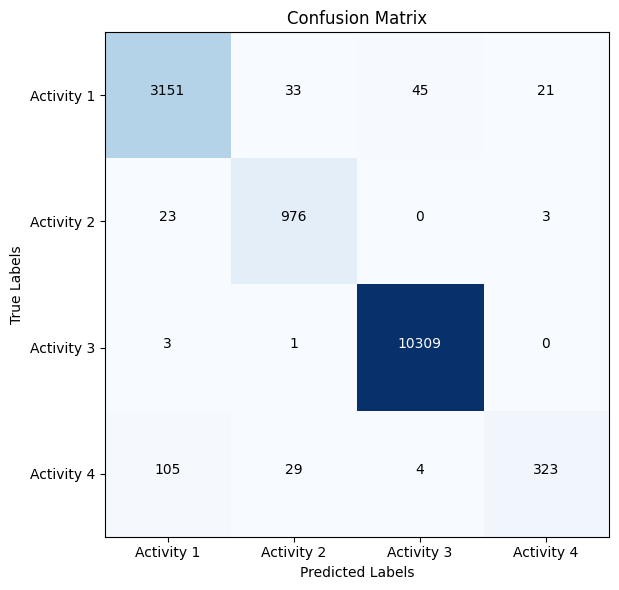

In [16]:
#knn5 reults
results_dict["KNN5"] = eval_classifier(knn5)

With a higher number of neighbors, the classifier did worse than with 3. It had 105 activities misclassified as activity 4. It slightly improved classification for activity 2, however.

Accuracy: 0.9740449886862771
Precision: 0.9734185655706558
Recall: 0.9740449886862771
F1-score: 0.9720380815982735
Confusion Matrix:


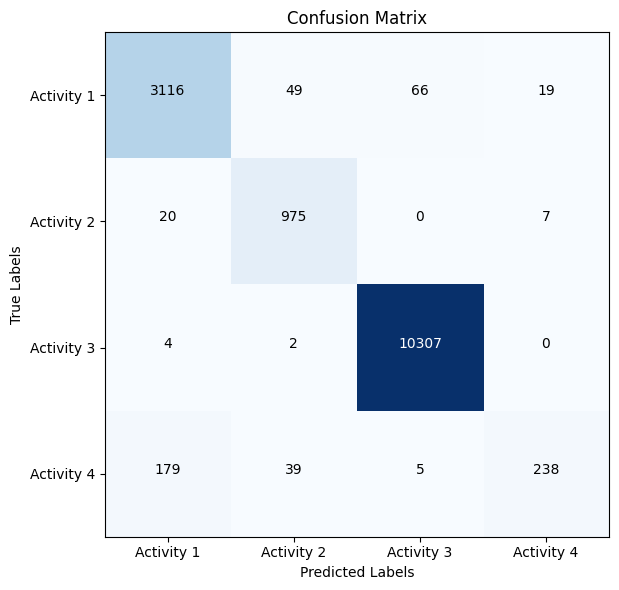

In [17]:
#knn10 reults
results_dict["KNN10"] = eval_classifier(knn10)

With more neighbors, activity 2 had improved classification again, but classification for activity 4 got worse.

Accuracy: 0.9847597497670704
Precision: 0.984834950636602
Recall: 0.9847597497670704
F1-score: 0.9841638347073585
Confusion Matrix:


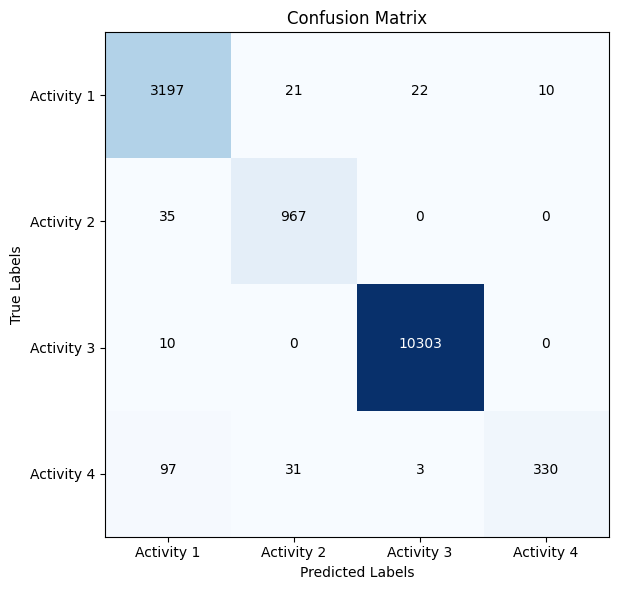

In [18]:
#test with 2 neighbors
knn2 = make_pipeline(StandardScaler(),KNeighborsClassifier(n_neighbors=2))

results_dict['KNN2'] = eval_classifier(knn2)

Two neighbors seemed to make the results worse for multiple activities, so 3 neighbors seems like it may be the ideal value of k for this type of classification method.

Accuracy: 0.9399707174231332
Precision: 0.9397463272236635
Recall: 0.9399707174231332
F1-score: 0.93541063832231
Confusion Matrix:


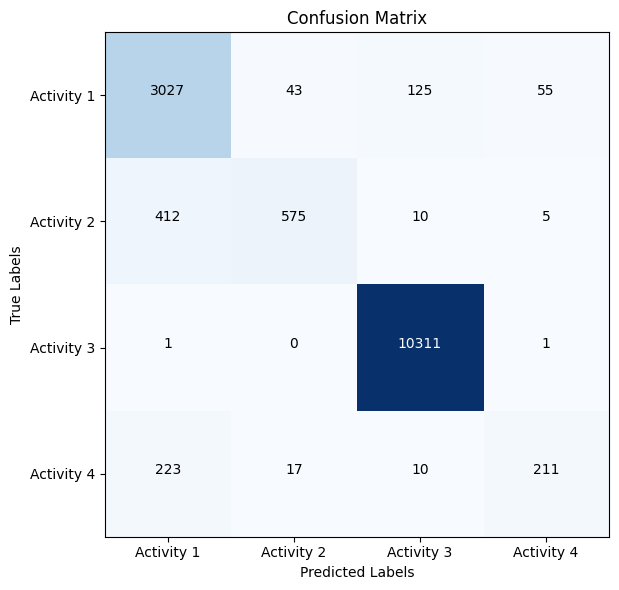

In [19]:
#naive bayes results
results_dict["Naive Bayes"] = eval_classifier(naive_bayes)

Naive Bayes had a very poor result for both activities 2 and 4. For activity 2, the incorrect classification as activity 2 was almost 50%. For activity 4, it was incorrectly classified more often that correctly.

Accuracy: 0.9093571143351524
Precision: 0.911266362899909
Recall: 0.9093571143351524
F1-score: 0.8868852139313627
Confusion Matrix:


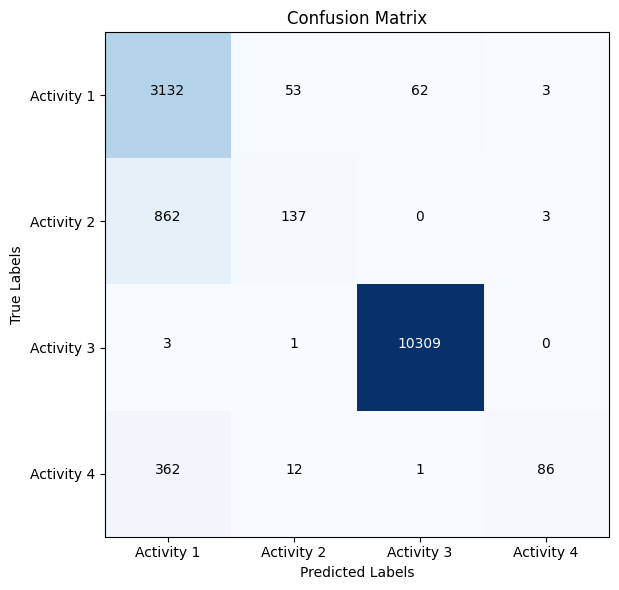

In [20]:
#lda results
results_dict["LDA"] = eval_classifier(lda)

Linear discriminant analysis also had a very bad classification for activities 2 and 4, which were classified as activity 1 most of the time.

Accuracy: 0.9707839744442965
Precision: 0.9697366516518108
Recall: 0.9707839744442965
F1-score: 0.9691499964700969
Confusion Matrix:


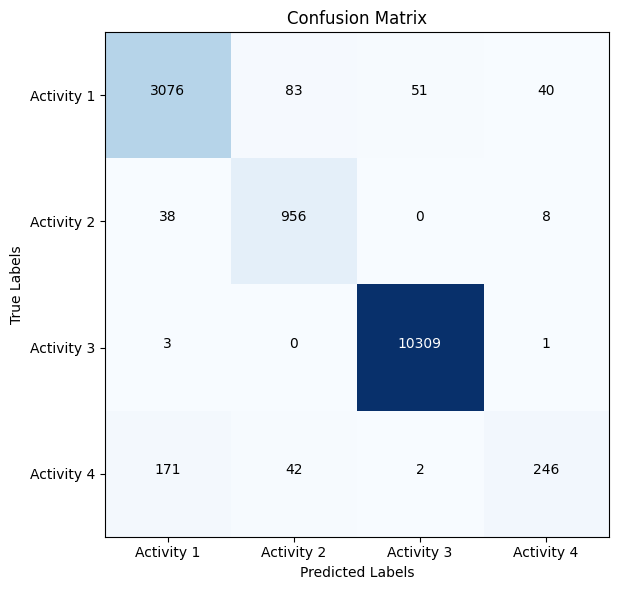

In [21]:
#rbf kda results
results_dict["RBF KDA"] = eval_classifier(kda_rbf)

Kernel discriminant analysis using rbf had better results than most of the other classification methods, but KNN still did a better job of classifying both activities 2 and 4.

Accuracy: 0.9681219220018634
Precision: 0.9675636368776198
Recall: 0.9681219220018634
F1-score: 0.9658835818739177
Confusion Matrix:


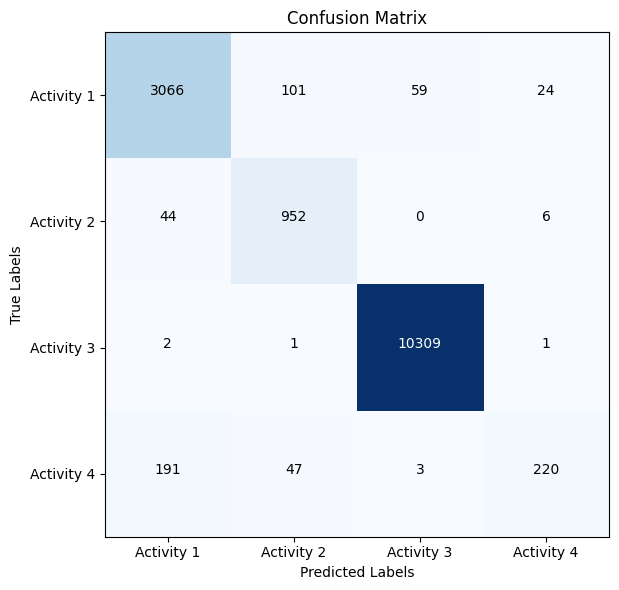

In [22]:
#poly kda results
results_dict["Poly KDA"] = eval_classifier(kda_poly)

Kernel discriminant anlysis using the polynomial kernel also had better results than naive bayes, LDA, and SVM, but it was not as good as KNN classifiers.

In [23]:
#Create a function to compare methods
def compare_methods(comparison_dict):
  #function to compare the
  #extract the methods used
  methods = list(comparison_dict.keys())

  #extract the accuracies, precisions, and recalls for each method
  accuracies = [comparison_dict[method]['accuracy'] for method in methods]
  precisions = [comparison_dict[method]['precision'] for method in methods]
  recalls = [comparison_dict[method]['recall'] for method in methods]
  f1_score = [comparison_dict[method]['f1'] for method in methods]

  #create a bar chart to compare

  #get locations for bars
  xlocs = np.arange(len(methods))
  #set width for each bar
  bar_width = 0.2

  #create bar chart
  plt.figure(figsize=(10,6))

  plt.bar(xlocs-bar_width, accuracies, width=bar_width, label='Accuracy')
  plt.bar(xlocs, precisions, width=bar_width, label='Precision')
  plt.bar(xlocs+bar_width, recalls, width=bar_width, label='Recall')
  plt.bar(xlocs+bar_width*2, f1_score, width=bar_width, label='F1-score')

  #calculate min and max values to show more precise details
  all_vals=accuracies+precisions+recalls+f1_score
  min_val = min(all_vals)
  max_val = max(all_vals)

  #get range of vals
  range_val = max_val-min_val
  margin = range_val*0.1 if range_val > 0 else 0.05

  #set y limits
  plt.ylim(max(0, min_val-margin), min(1, max_val+margin))

  #set xticks
  plt.xticks(xlocs, methods)
  plt.legend()
  plt.title(' Compare Accuracy, Precision, Recall, and F1 for Different Classification Methods ')
  plt.xlabel(f' Classification Metrics')
  plt.ylabel(' Score ')
  #plt.grid()

  plt.show()

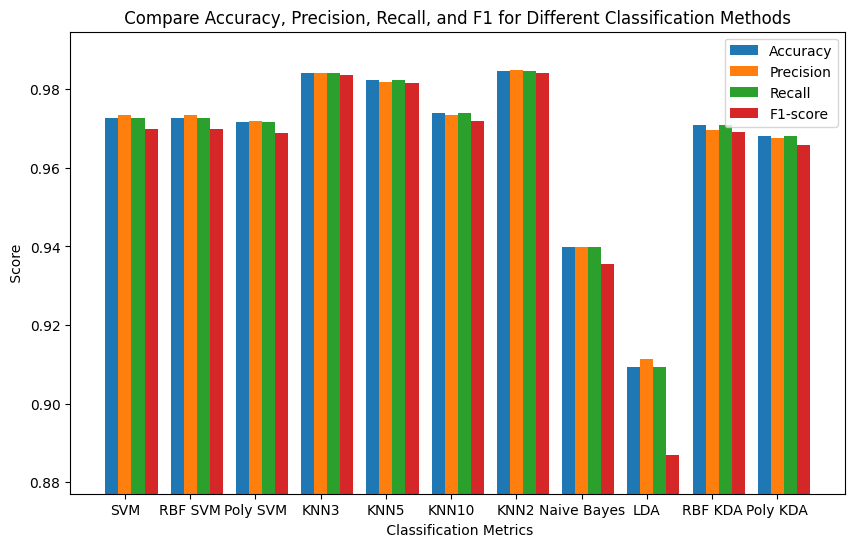

In [24]:
compare_methods(results_dict)

The results from the accuracy, precision, and recall visualization supports the confusion matrix results. KNN3 has the highest results overall, but KNN2 was not far behind.  

**Part 3: Dimensionality Reduction Using PCA**

**3.1 PCA**

* Apply PCA to reduce the dimensionality of the dataset.

* Retain components that explain at least 95% of the variance.

* Visualize the first 2 principal components with class labels.

In [25]:
"""
* Apply PCA to reduce the dimensionality of the dataset
"""

#get best n to retain variance
pca = PCA()
pca.fit(X_train)

#get explained variance ratio sum
variance = np.cumsum(pca.explained_variance_ratio_)

min_ind = [idx for idx, val in enumerate(variance) if val >= 0.95][0]+1

print(f"The minimum number of components to retain 95% of the variance is {min_ind}")

The minimum number of components to retain 95% of the variance is 1


In [26]:
"""
* Retain components that explain at least 95% of the variance.
"""

pca_95 = PCA(n_components = max(min_ind, 2))
pca_95.fit(X_train)

PCA(n_components=2)

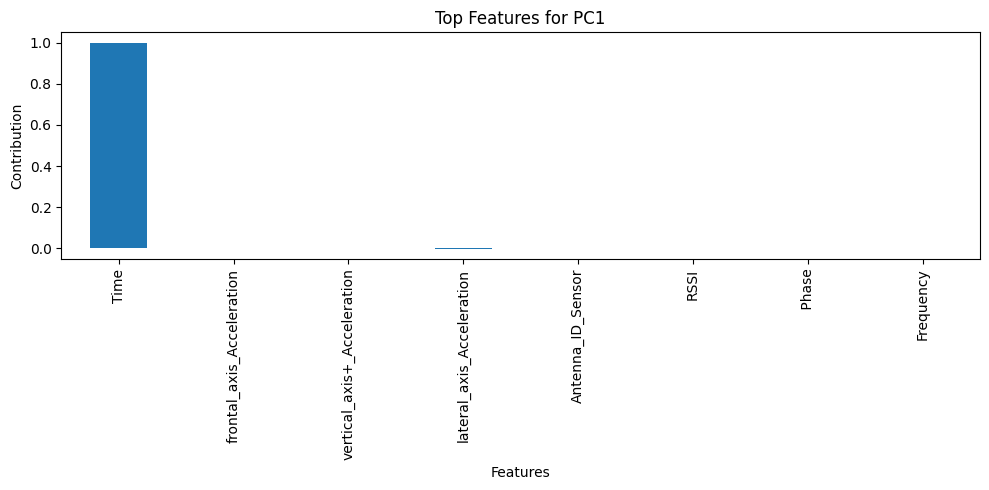

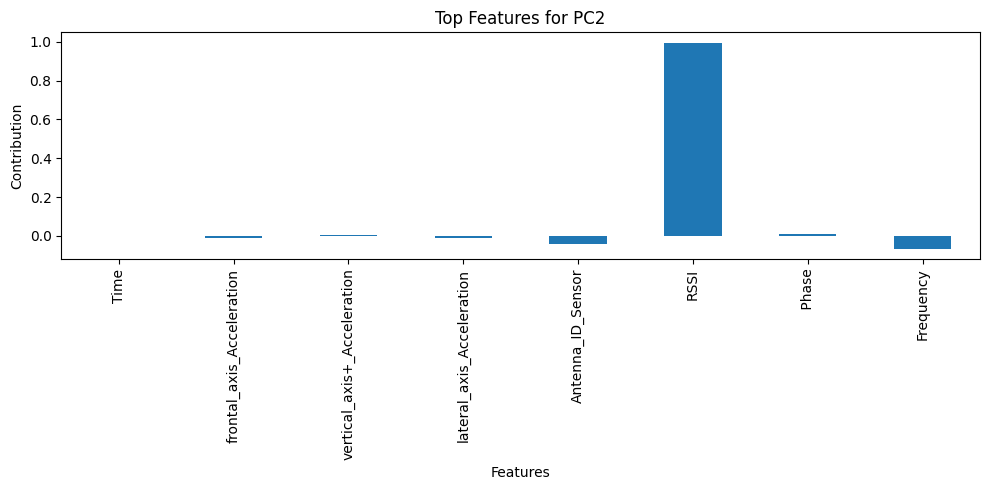

In [27]:
"""
* Visualize the first 2 principal components with class labels.
"""

#transform dataset
X_train_pca = pca_95.transform(X_train)
X_test_pca = pca_95.transform(X_test)

pd_data = df.iloc[:,:-1]

#get all component contributions to first two principal components
components = pd.DataFrame(pca_95.components_, columns=pd_data.columns, index=['PC1', 'PC2'])

#sort component features by absolute value
top_pc1 = components.loc['PC1'].abs().sort_values(ascending=False)
top_pc2 = components.loc['PC2'].abs().sort_values(ascending=False)

#Plot top two components
#first component
plt.figure(figsize=(10,5))
components.loc['PC1'].plot(kind='bar')
plt.title('Top Features for PC1')
plt.xlabel('Features')
plt.ylabel('Contribution')
plt.tight_layout()
plt.show()

#second component
plt.figure(figsize=(10,5))
components.loc['PC2'].plot(kind='bar')
plt.title('Top Features for PC2')
plt.xlabel('Features')
plt.ylabel('Contribution')
plt.tight_layout()
plt.show()

The component analysis shows that time maintains the highest contribution to the first principal component, and RSSI has the highest contribution to the second principal component.

**Part 4: Feature Selection**

**4.1 Apply the following feature selection methods:**

* Chi-Squared (chi2)

* Information Gain (Mutual Information)

* LASSO (L1-Regularized Logistic Regression)

In [28]:
"""
4.1 Apply the following feature selection methods:

Chi-Squared (chi2)

Source used: https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html#sphx-glr-auto-examples-compose-plot-column-transformer-mixed-types-py
"""
#retrieve feature names from original dataset
original_feature_names = df.columns[:-1]

#create pipeline for chi2
#use MinMaxScaler to handle negative values
chi_s = make_pipeline(MinMaxScaler(), SelectKBest(chi2, k=5))
chi_s.fit(X_train, y_train)

#get selected feature mask
mask = chi_s.named_steps['selectkbest'].get_support()

#Map features to their names
selected_feature_names = original_feature_names[mask]

#print selected feature names
print(f"Selected features for chi squared selection: ")

for feature in selected_feature_names:
  print(feature)


Selected features for chi squared selection: 
Time
frontal_axis_Acceleration
vertical_axis+_Acceleration
lateral_axis_Acceleration
Antenna_ID_Sensor


In [29]:
"""
* Information Gain (Mutual Information)
"""

#create pipeline for mutual information
mi_s = make_pipeline(StandardScaler(), SelectKBest(mutual_info_classif, k=5))
mi_s.fit(X_train, y_train)

#get selected feature mask
mask = mi_s.named_steps['selectkbest'].get_support()

#Map features to their names
selected_feature_names = original_feature_names[mask]

#print selected feature names
print(f"Selected features for mutual information selection: ")

for feature in selected_feature_names:
  print(feature)

Selected features for mutual information selection: 
Time
frontal_axis_Acceleration
vertical_axis+_Acceleration
lateral_axis_Acceleration
Antenna_ID_Sensor


In [30]:
"""
* LASSO (L1-Regularized Logistic Regression)
source used: https://scikit-learn.org/stable/modules/feature_selection.html#l1-feature-selection
"""


#create pipeline for lasso
lasso_s = make_pipeline(StandardScaler(), SelectFromModel(Lasso(alpha=0.01)))
lasso_s.fit(X_train, y_train)

#get selected feature mask
mask=lasso_s.named_steps['selectfrommodel'].get_support()

#Map features to their names
selected_feature_names = original_feature_names[mask]

#print selected feature names

print(f"Selected features for lasso selection: ")

for feature in selected_feature_names:
  print(feature)


Selected features for lasso selection: 
frontal_axis_Acceleration
vertical_axis+_Acceleration
lateral_axis_Acceleration
Antenna_ID_Sensor
RSSI
Frequency


All three feature selection methods had frontal_axis_Acceleration, vertical_axis+_Acceleration, lateral_axis_Acceleration, and Antenna_ID_Sensor as selected features. The methods that used SelectKBest both had Time as the top selected feature, but this feature was not selected when using Lasso. Time might not have been as important for Lasso selection because Lasso is a linear method and its effect might not be seen as effectively as when using chi-squared or mutual information. It appears that the core features to select would be the one that appear in all classification methods.

**Part 5: Classification with Reduced Feature Sets**

**5.1 PCA-Reduced Data**

Apply all classifiers again on the PCA-reduced data:

* SVM (Linear and Kernel)

* KNN

* Naive Bayes

* LDA

* KDA

**5.2 Selected Features**

For each of the three feature selection methods (Chi2, InfoGain, LASSO), apply the classifiers on the selected features:

* SVM

* KNN

* Naive Bayes

* LDA

* KDA

**5.3 Neural Network**

Build a simple Neural Network using either MLPClassifier from scikit-learn or a Pytorch model. Train and evaluate it using:

* The full feature set

* PCA-reduced data

* Feature-selected data



In [31]:
"""
5.1 PCA-Reduced Data

Apply all classifiers again on the PCA-reduced data:
SVM (Linear and Kernel)
KNN
Naive Bayes
LDA
KDA
"""

#pipelines for PCA reduced data with classifiers
#create each classifier
p_svm = make_pipeline(StandardScaler(),PCA(n_components=5), SVC())
p_svm_rbf = make_pipeline(StandardScaler(), PCA(n_components=5), SVC(kernel='rbf'))
p_svm_poly = make_pipeline(StandardScaler(), PCA(n_components=5), SVC(kernel='poly'))
p_knn3 = make_pipeline(StandardScaler(),PCA(n_components=5), KNeighborsClassifier(n_neighbors=3))
p_knn5 = make_pipeline(StandardScaler(),PCA(n_components=5), KNeighborsClassifier(n_neighbors=5))
p_knn10 = make_pipeline(StandardScaler(),PCA(n_components=5), KNeighborsClassifier(n_neighbors=10))
p_naive_bayes = make_pipeline(StandardScaler(),PCA(n_components=5), GaussianNB())
p_lda = make_pipeline(StandardScaler(),PCA(n_components=5), LinearDiscriminantAnalysis())

p_kda_rbf = make_pipeline(StandardScaler(), PCA(n_components=5), rbf_transformer, LinearDiscriminantAnalysis())
p_kda_poly = make_pipeline(StandardScaler(), PCA(n_components=5), poly_transformer, LinearDiscriminantAnalysis())

Originally, 2 components were used since observations earlier showed that only 1 component was needed to achieve 95% variance, however the results were poor for some activities, so it was changed to 5 components.

Accuracy: 0.9482896313057367
Precision: 0.9498735988444996
Recall: 0.9482896313057367
F1-score: 0.9442104660328878
Confusion Matrix:


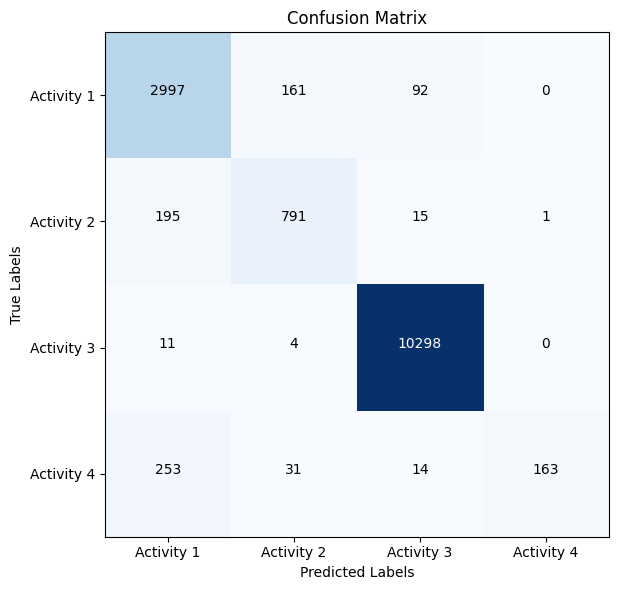

In [32]:
results_dict["PCA + SVM"] = eval_classifier(p_svm)

Accuracy: 0.9482896313057367
Precision: 0.9498735988444996
Recall: 0.9482896313057367
F1-score: 0.9442104660328878
Confusion Matrix:


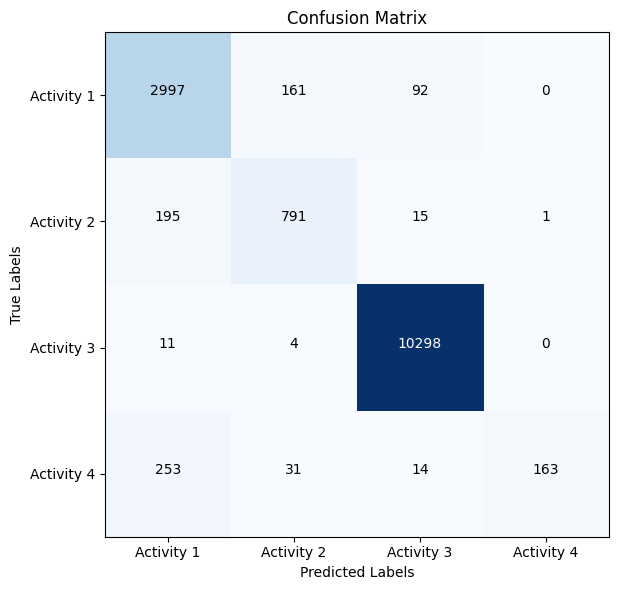

In [33]:
results_dict["PCA + RBF SVM"] = eval_classifier(p_svm_rbf)

Accuracy: 0.9337814454944763
Precision: 0.9341111367220236
Recall: 0.9337814454944763
F1-score: 0.9285836054258556
Confusion Matrix:


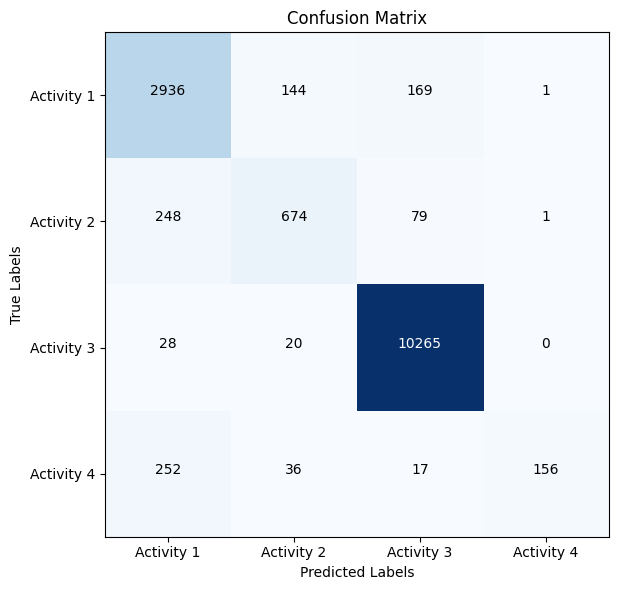

In [34]:
results_dict["PCA + Poly SVM"] = eval_classifier(p_svm_poly)

Accuracy: 0.971382936243844
Precision: 0.9710312065001449
Recall: 0.971382936243844
F1-score: 0.9707691949980651
Confusion Matrix:


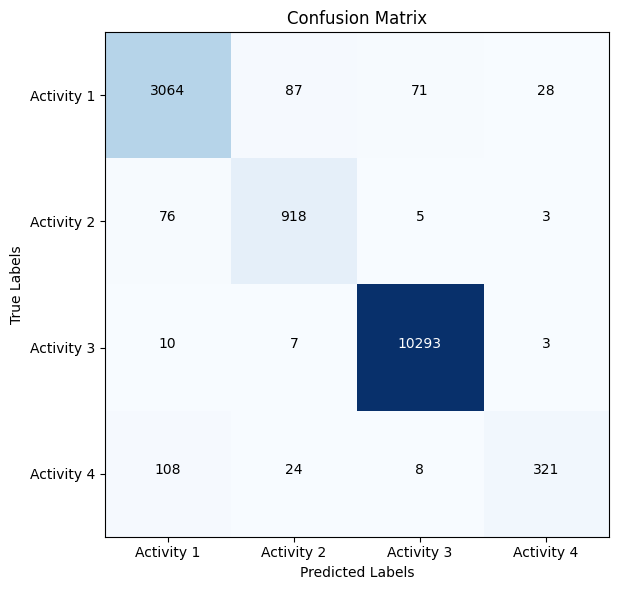

In [35]:
results_dict["PCA + KNN3"] = eval_classifier(p_knn3)

Accuracy: 0.9683881272461068
Precision: 0.967804263550789
Recall: 0.9683881272461068
F1-score: 0.9675978165649947
Confusion Matrix:


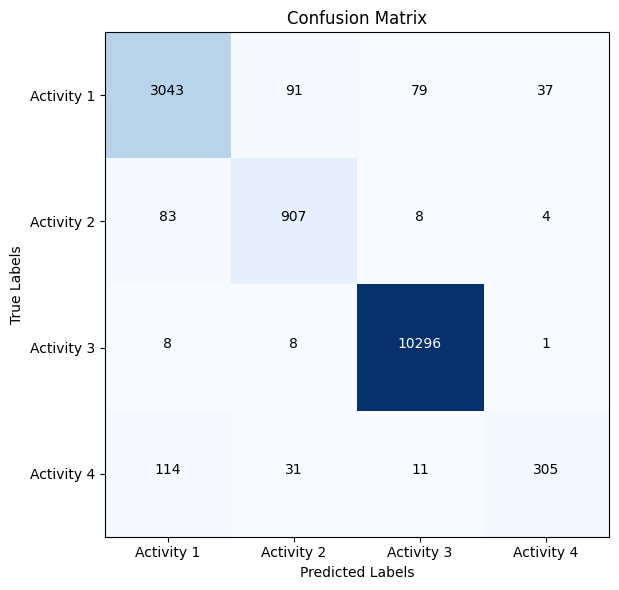

In [36]:
results_dict["PCA + KNN5"] = eval_classifier(p_knn5)

Accuracy: 0.9584054305869826
Precision: 0.956803703790697
Recall: 0.9584054305869826
F1-score: 0.9559352016925948
Confusion Matrix:


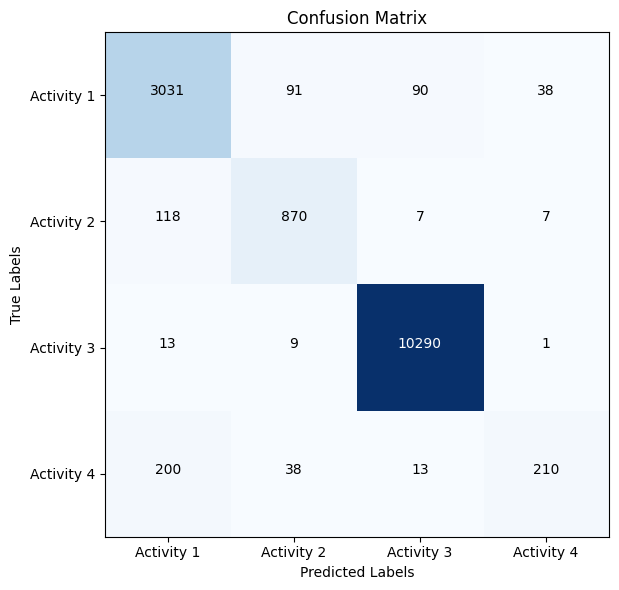

In [37]:
results_dict["PCA + KNN10"] = eval_classifier(p_knn10)

Accuracy: 0.8902568880606948
Precision: 0.8997120042099082
Recall: 0.8902568880606948
F1-score: 0.8594030308260684
Confusion Matrix:


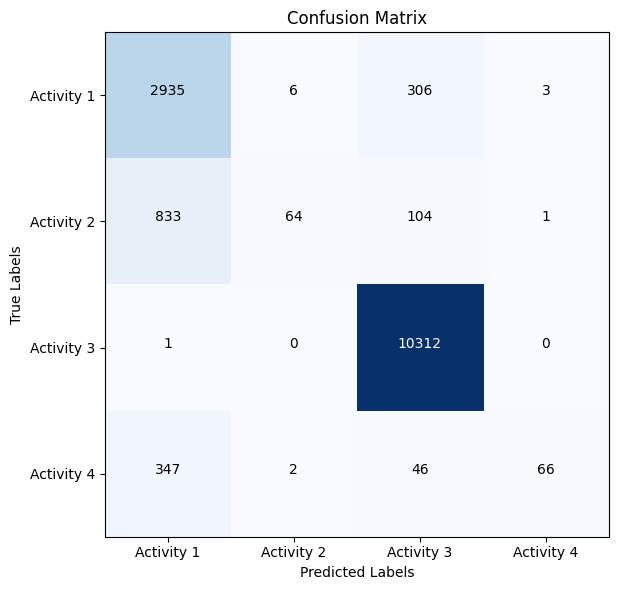

In [38]:
results_dict["PCA + Naive Bayes"] = eval_classifier(p_naive_bayes)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.8832690003993079
Precision: 0.8177304913562526
Recall: 0.8832690003993079
F1-score: 0.8447729214843336
Confusion Matrix:


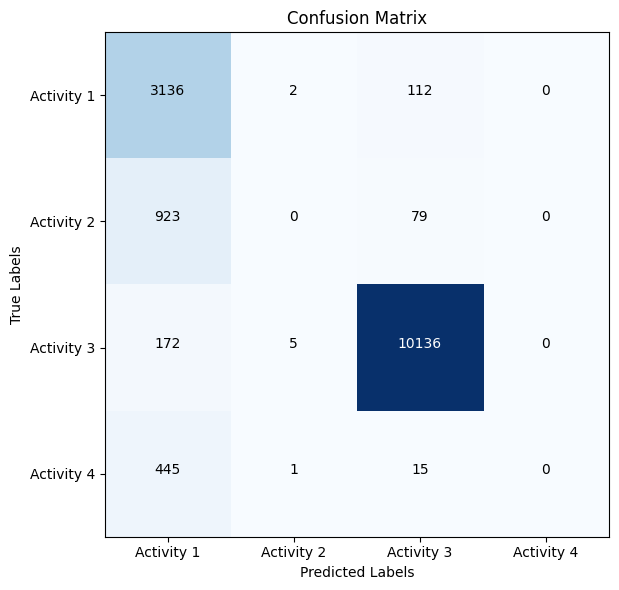

In [39]:
results_dict["PCA + LDA"] = eval_classifier(p_lda)

Accuracy: 0.9444296552642087
Precision: 0.9434722951952481
Recall: 0.9444296552642087
F1-score: 0.9425797109801866
Confusion Matrix:


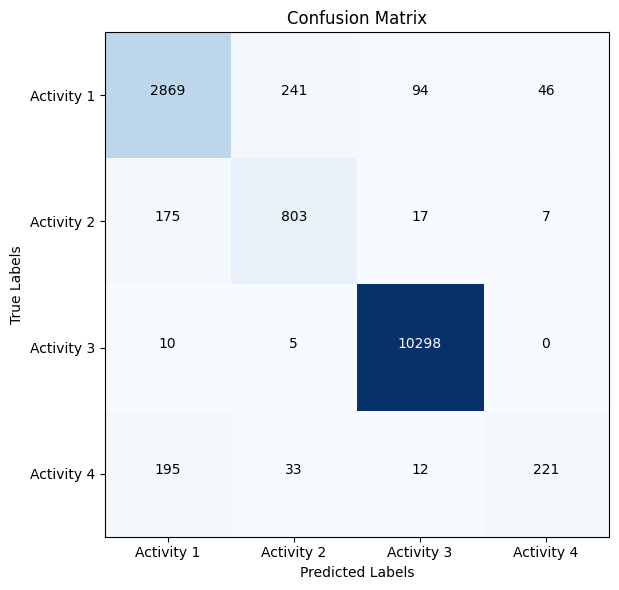

In [40]:
results_dict["PCA + RBF KDA"] = eval_classifier(p_kda_rbf)

Accuracy: 0.9233994409689871
Precision: 0.9219969277125267
Recall: 0.9233994409689871
F1-score: 0.9217860824785113
Confusion Matrix:


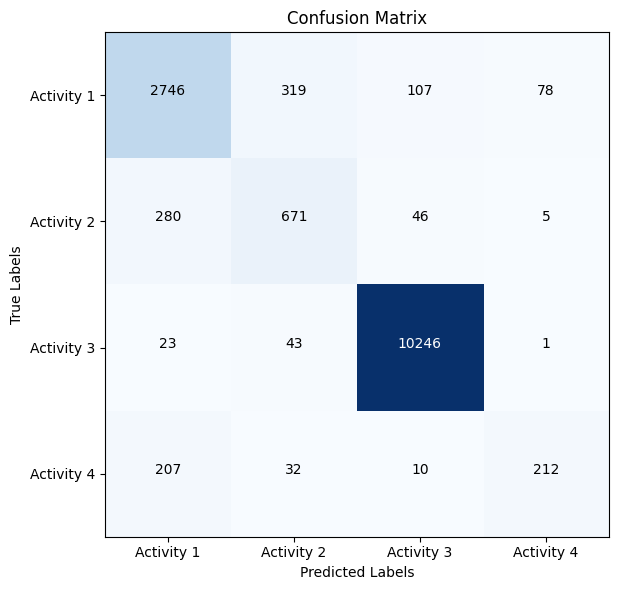

In [41]:
results_dict["PCA + Poly KDA"] = eval_classifier(p_kda_poly)

In [42]:
"""
5.2 Selected Features
For each of the three feature selection methods (Chi2, InfoGain, LASSO), apply the classifiers on the selected features:
SVM
KNN
Naive Bayes
LDA
KDA
"""

#transform using each feature selection method
X_train_chi = chi_s.transform(X_train)
X_test_chi = chi_s.transform(X_test)

X_train_mi = mi_s.transform(X_train)
X_test_mi = mi_s.transform(X_test)

X_train_lasso = lasso_s.transform(X_train)
X_test_lasso = lasso_s.transform(X_test)

#Instantiate and fit each model
c_svm = SVC()
m_svm = SVC()
l_svm = SVC()

c_svm_rbf = SVC(kernel='rbf')
m_svm_rbf = SVC(kernel='rbf')
l_svm_rbf = SVC(kernel='rbf')

c_svm_poly = SVC(kernel='poly')
m_svm_poly = SVC(kernel='poly')
l_svm_poly = SVC(kernel='poly')

c_knn3 = KNeighborsClassifier(n_neighbors=3)
m_knn3 = KNeighborsClassifier(n_neighbors=3)
l_knn3 = KNeighborsClassifier(n_neighbors=3)

c_naive_bayes = GaussianNB()
m_naive_bayes = GaussianNB()
l_naive_bayes = GaussianNB()

c_lda = LinearDiscriminantAnalysis()
m_lda = LinearDiscriminantAnalysis()
l_lda = LinearDiscriminantAnalysis()

c_kda_rbf = make_pipeline(rbf_transformer, LinearDiscriminantAnalysis())
m_kda_rbf = make_pipeline(rbf_transformer, LinearDiscriminantAnalysis())
l_kda_rbf = make_pipeline(rbf_transformer, LinearDiscriminantAnalysis())

c_kda_poly = make_pipeline(poly_transformer, LinearDiscriminantAnalysis())
m_kda_poly = make_pipeline(poly_transformer, LinearDiscriminantAnalysis())
l_kda_poly = make_pipeline(poly_transformer, LinearDiscriminantAnalysis())

Accuracy: 0.9538799414348462
Precision: 0.9486236555947484
Recall: 0.9538799414348462
F1-score: 0.9451552285864456
Confusion Matrix:


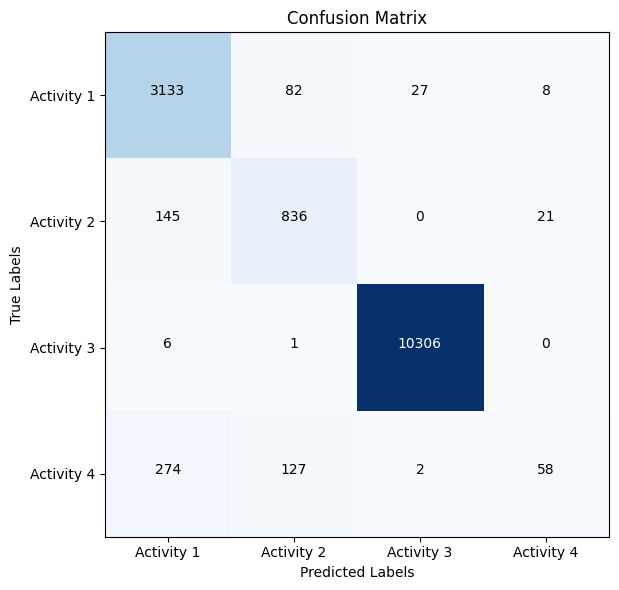

In [43]:
results_dict["Chi2 + SVM"] = eval_classifier(c_svm, X_train=X_train_chi, X_test=X_test_chi)

Accuracy: 0.957873020098496
Precision: 0.9538770266492987
Recall: 0.957873020098496
F1-score: 0.9500201021096757
Confusion Matrix:


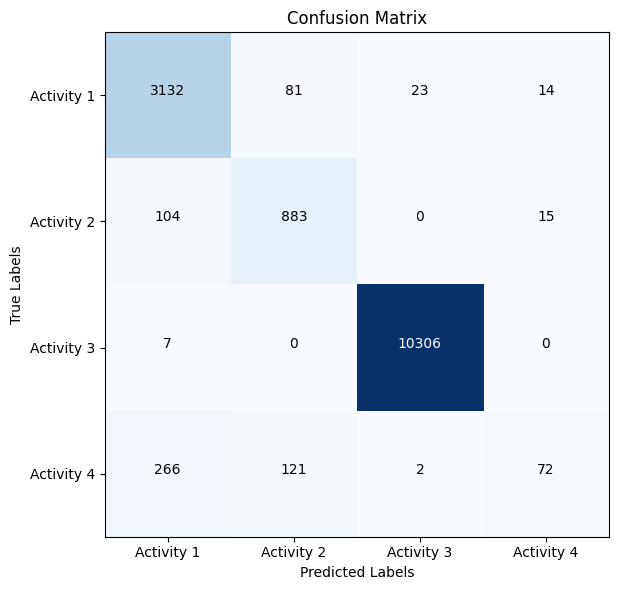

In [44]:
results_dict["Mutual Information + SVM"] = eval_classifier(m_svm, X_train=X_train_mi, X_test=X_test_mi)

Accuracy: 0.9701850126447491
Precision: 0.9712847145439901
Recall: 0.9701850126447491
F1-score: 0.9671065007741321
Confusion Matrix:


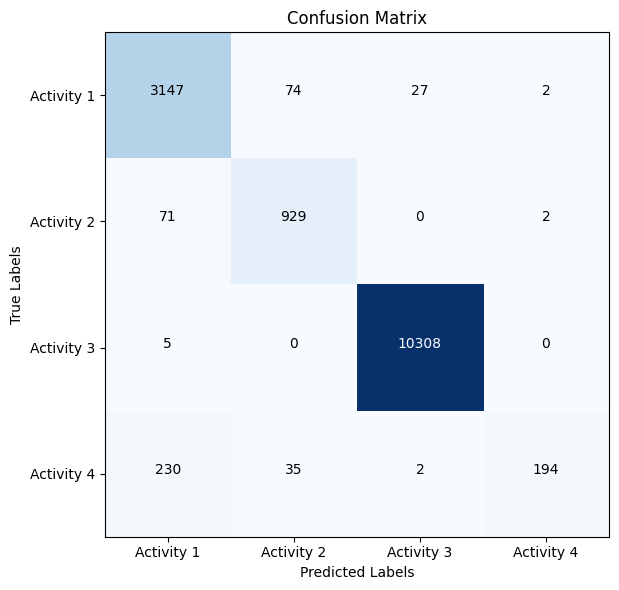

In [45]:
results_dict["Lasso + SVM"] = eval_classifier(l_svm, X_train=X_train_lasso, X_test=X_test_lasso)

Accuracy: 0.9538799414348462
Precision: 0.9486236555947484
Recall: 0.9538799414348462
F1-score: 0.9451552285864456
Confusion Matrix:


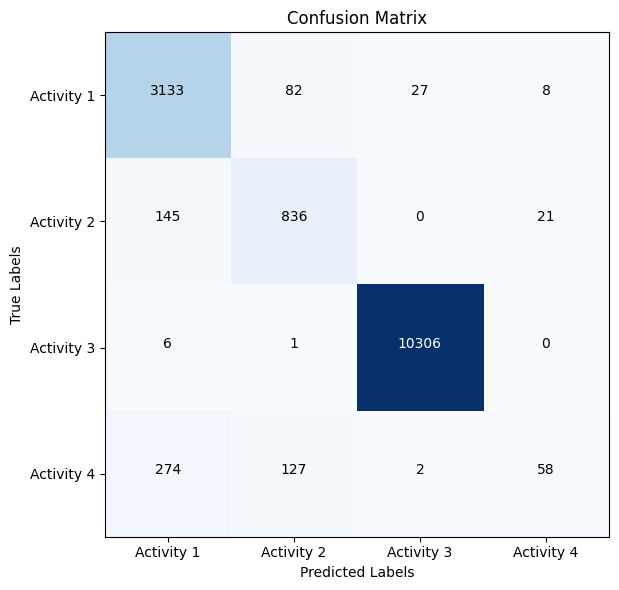

In [46]:
results_dict["Chi2 + RBF SVM"] = eval_classifier(c_svm_rbf, X_train=X_train_chi, X_test=X_test_chi)

Accuracy: 0.957873020098496
Precision: 0.9538770266492987
Recall: 0.957873020098496
F1-score: 0.9500201021096757
Confusion Matrix:


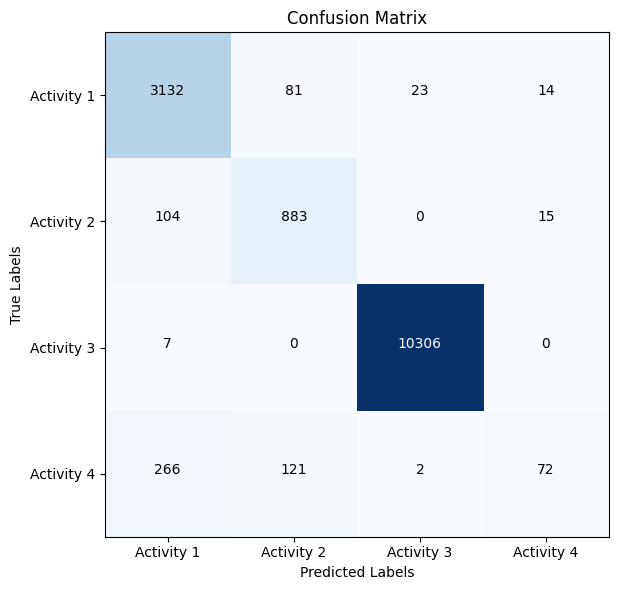

In [47]:
results_dict["Mutual Information + RBF SVM"] = eval_classifier(m_svm_rbf, X_train=X_train_mi, X_test=X_test_mi)

Accuracy: 0.9701850126447491
Precision: 0.9712847145439901
Recall: 0.9701850126447491
F1-score: 0.9671065007741321
Confusion Matrix:


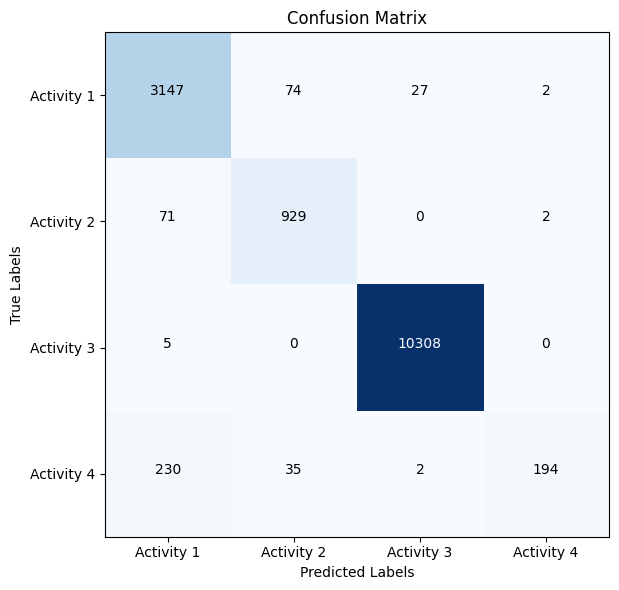

In [48]:
results_dict["Lasso + RBF SVM"] = eval_classifier(l_svm_rbf, X_train=X_train_lasso, X_test=X_test_lasso)

Accuracy: 0.9541461466790896
Precision: 0.9500615715345065
Recall: 0.9541461466790896
F1-score: 0.9451100454970564
Confusion Matrix:


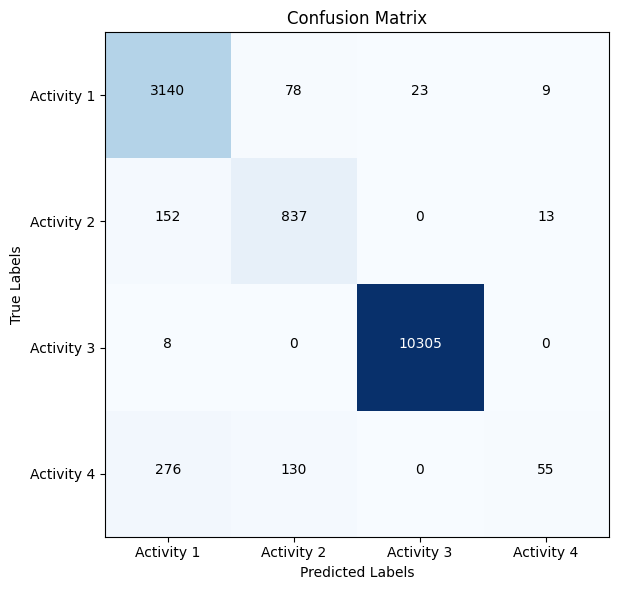

In [49]:
results_dict["Chi2 + Poly SVM"] = eval_classifier(c_svm_poly, X_train=X_train_chi, X_test=X_test_chi)

Accuracy: 0.9520165047251431
Precision: 0.9451774403853251
Recall: 0.9520165047251431
F1-score: 0.9421733912615678
Confusion Matrix:


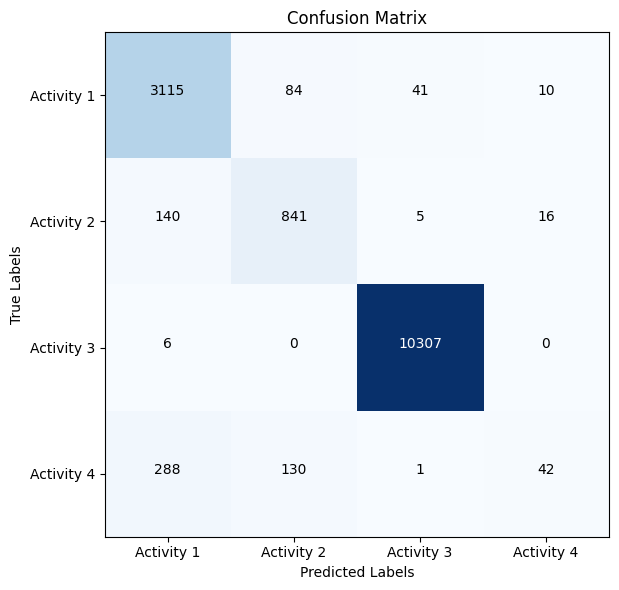

In [50]:
results_dict["Mutual Information + Poly SVM"] = eval_classifier(m_svm_poly, X_train=X_train_mi, X_test=X_test_mi)

Accuracy: 0.9666577931585252
Precision: 0.9672186762461121
Recall: 0.9666577931585252
F1-score: 0.9636737648992604
Confusion Matrix:


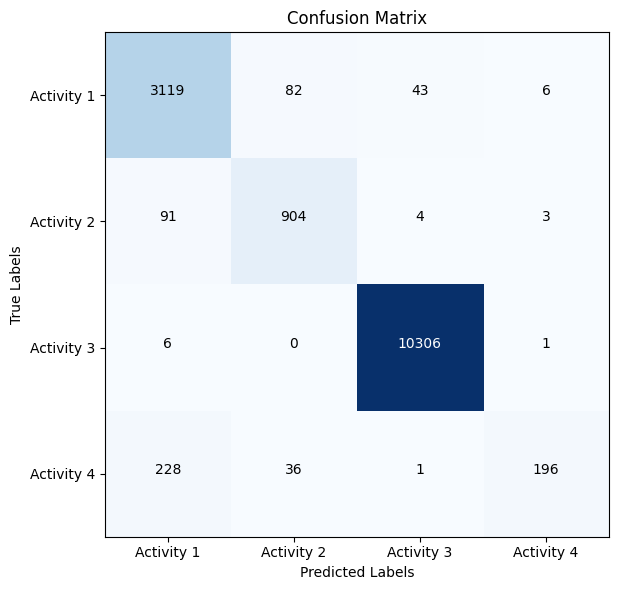

In [51]:
results_dict["Lasso + Poly SVM"] = eval_classifier(l_svm_poly, X_train=X_train_lasso, X_test=X_test_lasso)

Accuracy: 0.9858911220551045
Precision: 0.9855361348166906
Recall: 0.9858911220551045
F1-score: 0.9854857693986542
Confusion Matrix:


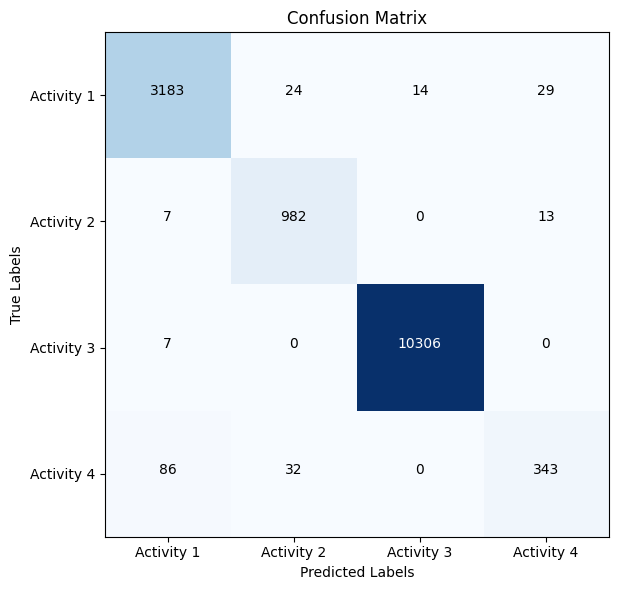

In [52]:
results_dict["Chi2 + KNN3"] = eval_classifier(c_knn3, X_train=X_train_chi, X_test=X_test_chi)

Accuracy: 0.957873020098496
Precision: 0.9538770266492987
Recall: 0.957873020098496
F1-score: 0.9500201021096757
Confusion Matrix:


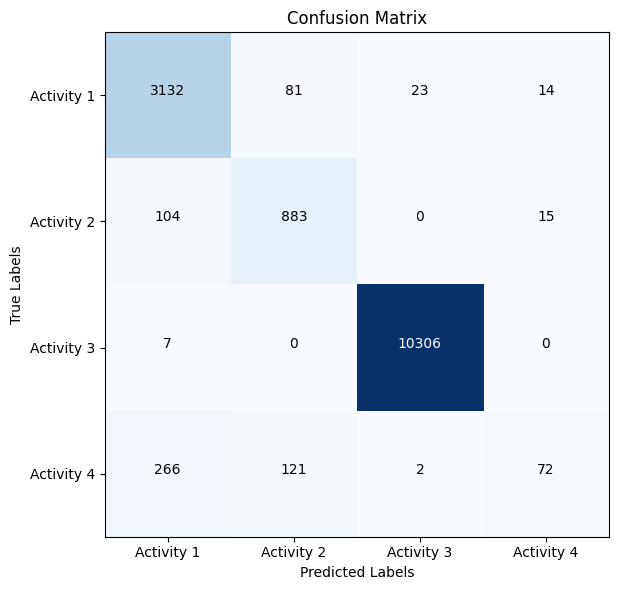

In [53]:
results_dict["Mutual Information + KNN3"] = eval_classifier(m_svm, X_train=X_train_mi, X_test=X_test_mi)

Accuracy: 0.9701850126447491
Precision: 0.9712847145439901
Recall: 0.9701850126447491
F1-score: 0.9671065007741321
Confusion Matrix:


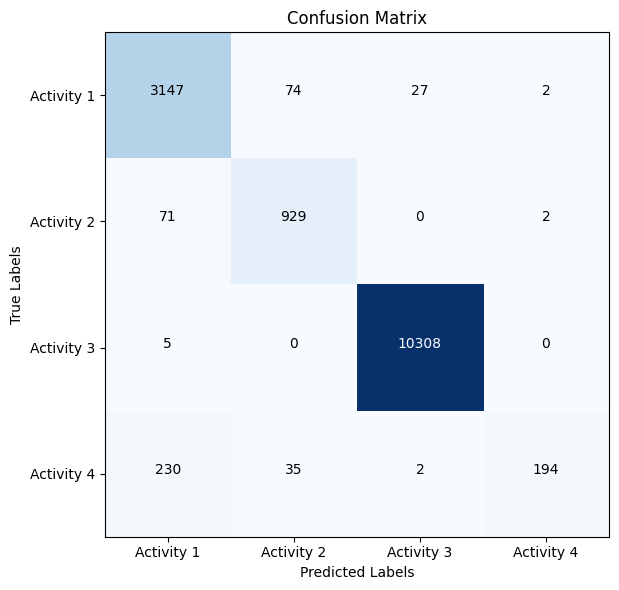

In [54]:
results_dict["Lasso + KNN3"] = eval_classifier(l_svm, X_train=X_train_lasso, X_test=X_test_lasso)

Accuracy: 0.9271263143883934
Precision: 0.9182488758550493
Recall: 0.9271263143883934
F1-score: 0.9160012522496633
Confusion Matrix:


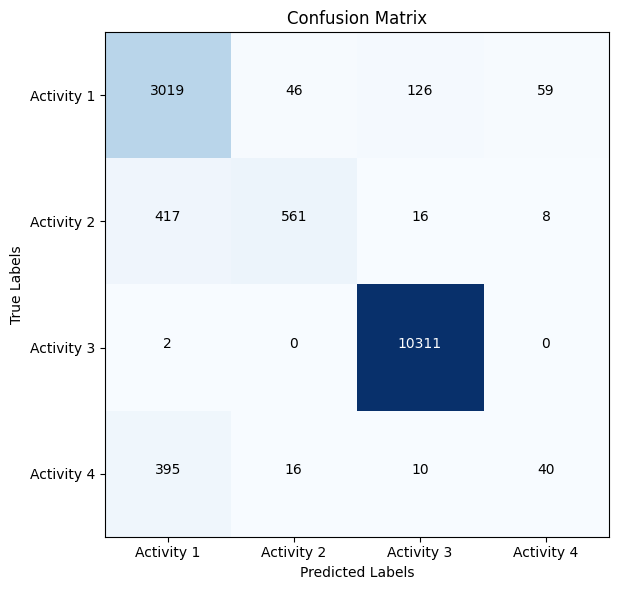

In [55]:
results_dict["Chi2 + Naive Bayes"] = eval_classifier(c_naive_bayes, X_train=X_train_chi, X_test=X_test_chi)

Accuracy: 0.9271263143883934
Precision: 0.9182488758550493
Recall: 0.9271263143883934
F1-score: 0.9160012522496633
Confusion Matrix:


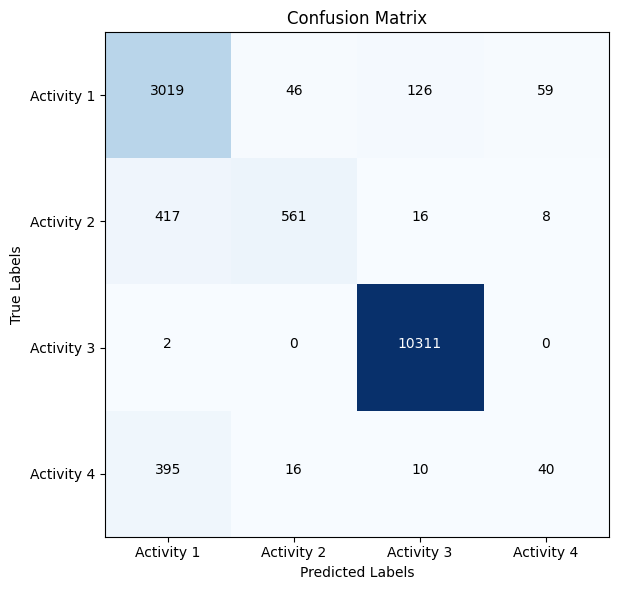

In [56]:
results_dict["Mutual Information + Naive Bayes"] = eval_classifier(m_naive_bayes, X_train=X_train_mi, X_test=X_test_mi)

Accuracy: 0.9414348462664714
Precision: 0.9410680704917674
Recall: 0.9414348462664714
F1-score: 0.936730033932212
Confusion Matrix:


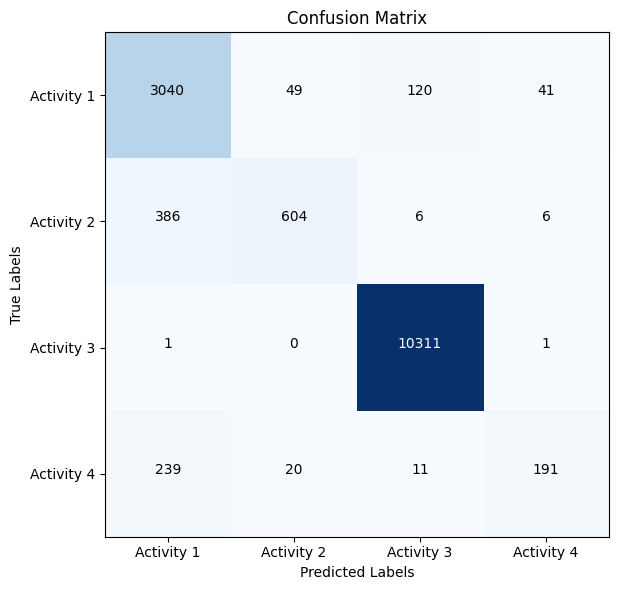

In [57]:
results_dict["Lasso + Naive Bayes"] = eval_classifier(l_naive_bayes, X_train=X_train_lasso, X_test=X_test_lasso)

Accuracy: 0.9024357779848263
Precision: 0.8915271153505048
Recall: 0.9024357779848263
F1-score: 0.8737622901488314
Confusion Matrix:


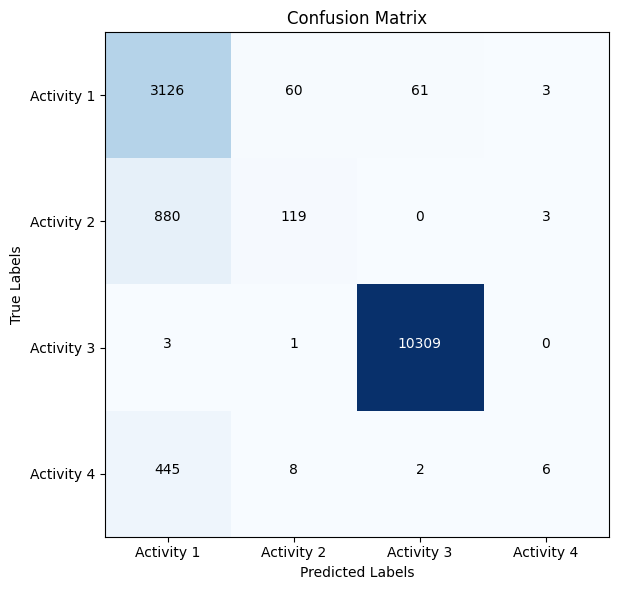

In [58]:
results_dict["Chi2 + LDA"] = eval_classifier(c_lda, X_train=X_train_chi, X_test=X_test_chi)

Accuracy: 0.9024357779848263
Precision: 0.8915271153505048
Recall: 0.9024357779848263
F1-score: 0.8737622901488314
Confusion Matrix:


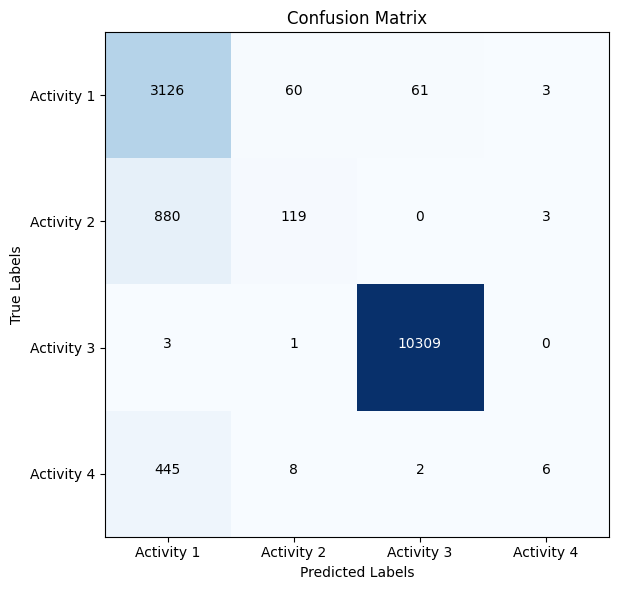

In [59]:
results_dict["Mutual Information + LDA"] = eval_classifier(m_lda, X_train=X_train_mi, X_test=X_test_mi)

Accuracy: 0.9068947158259018
Precision: 0.904389290403758
Recall: 0.9068947158259018
F1-score: 0.8826982833389887
Confusion Matrix:


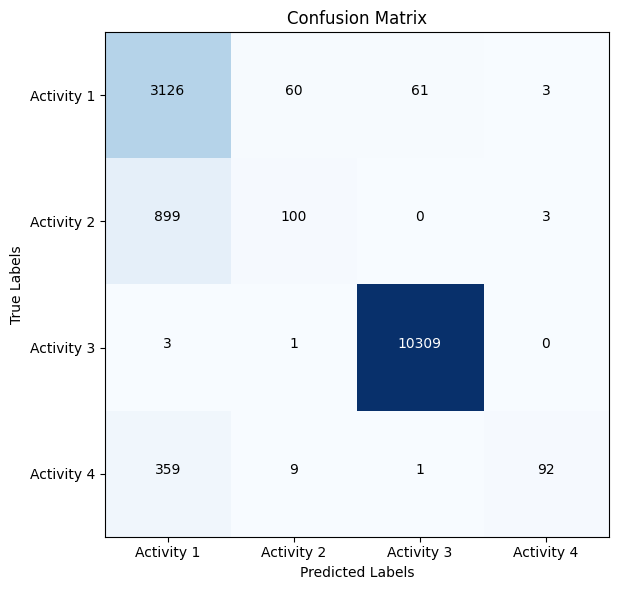

In [60]:
results_dict["Lasso + LDA"] = eval_classifier(l_lda, X_train=X_train_lasso, X_test=X_test_lasso)

Accuracy: 0.9513509916145348
Precision: 0.9475444815801313
Recall: 0.9513509916145348
F1-score: 0.9491325117621378
Confusion Matrix:


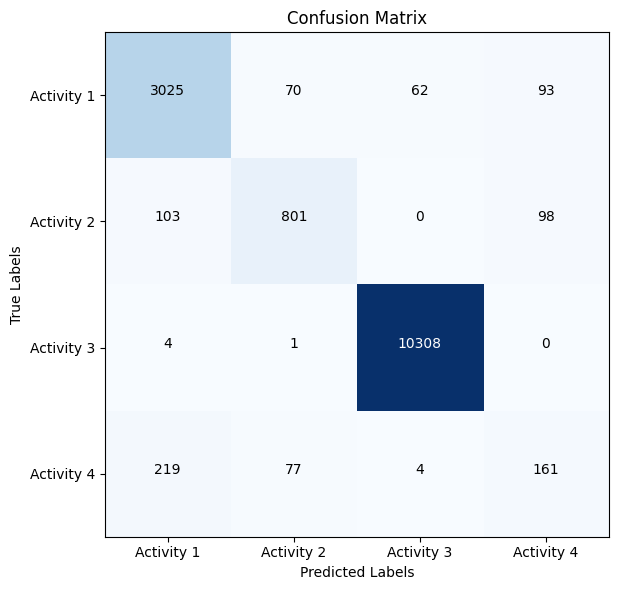

In [61]:
results_dict["Chi2 + RBF KDA"] = eval_classifier(c_kda_rbf, X_train=X_train_chi, X_test=X_test_chi)

Accuracy: 0.9618660987621456
Precision: 0.9596130014108954
Recall: 0.9618660987621456
F1-score: 0.9602156229370995
Confusion Matrix:


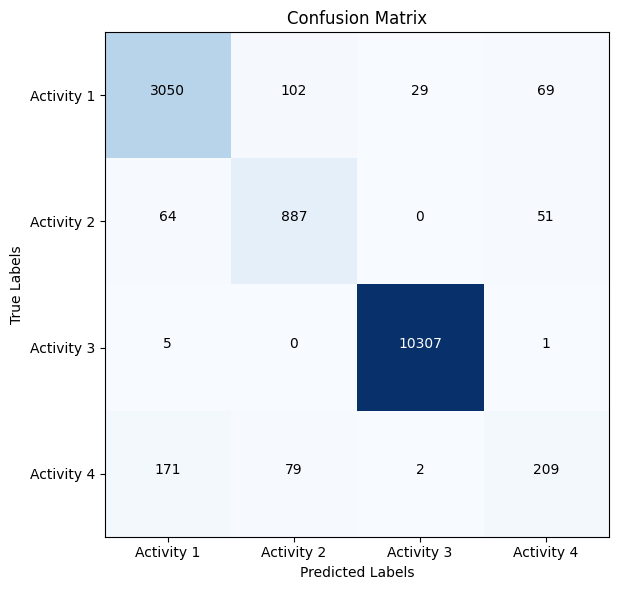

In [62]:
results_dict["Mutual Information + RBF KDA"] = eval_classifier(m_kda_rbf, X_train=X_train_mi, X_test=X_test_mi)

Accuracy: 0.9707839744442965
Precision: 0.9699377920152455
Recall: 0.9707839744442965
F1-score: 0.9693329854456065
Confusion Matrix:


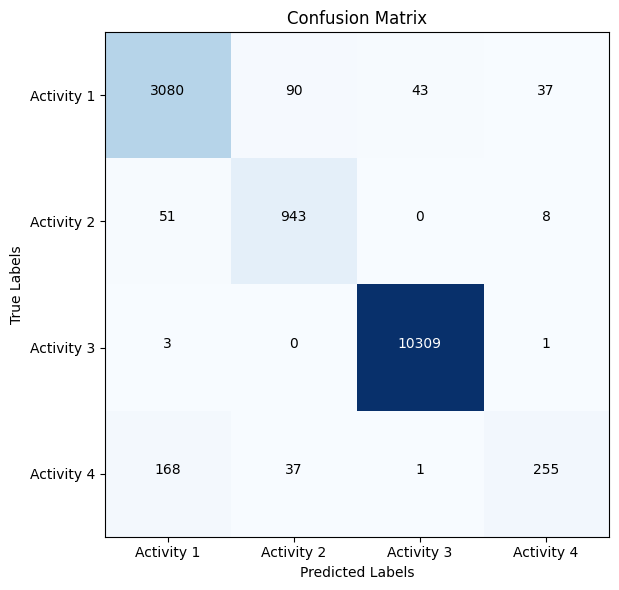

In [63]:
results_dict["Lasso + RBF KDA"] = eval_classifier(l_kda_rbf, X_train=X_train_lasso, X_test=X_test_lasso)

Accuracy: 0.9478903234393717
Precision: 0.9443315366592846
Recall: 0.9478903234393717
F1-score: 0.9458818632000511
Confusion Matrix:


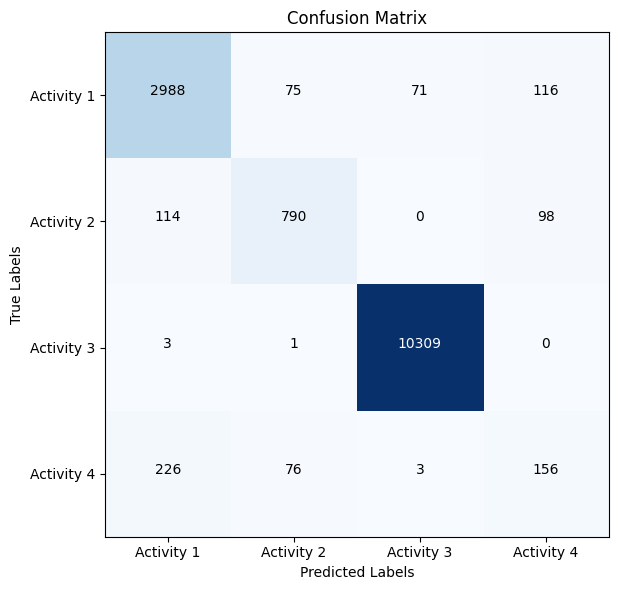

In [64]:
results_dict["Chi2 + Poly KDA"] = eval_classifier(c_kda_poly, X_train=X_train_chi, X_test=X_test_chi)

Accuracy: 0.9478903234393717
Precision: 0.9443315366592846
Recall: 0.9478903234393717
F1-score: 0.9458818632000511
Confusion Matrix:


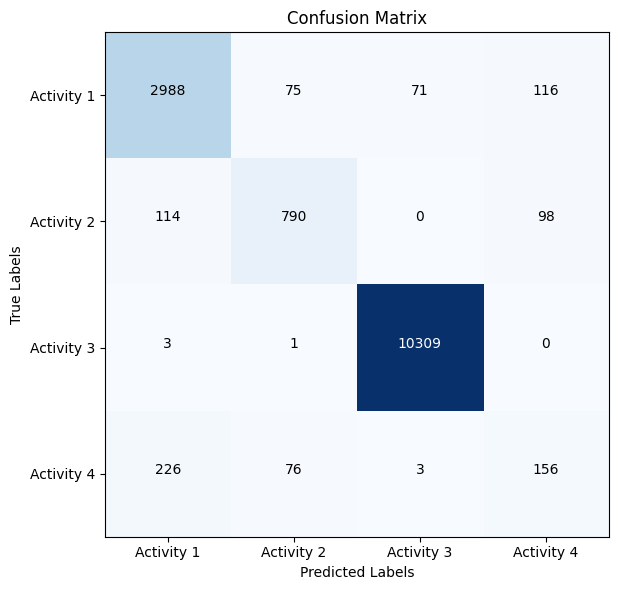

In [65]:
results_dict["Mutual Information + Poly KDA"] = eval_classifier(m_kda_poly, X_train=X_train_mi, X_test=X_test_mi)

Accuracy: 0.9642619459603354
Precision: 0.9638152149959663
Recall: 0.9642619459603354
F1-score: 0.9618882992225807
Confusion Matrix:


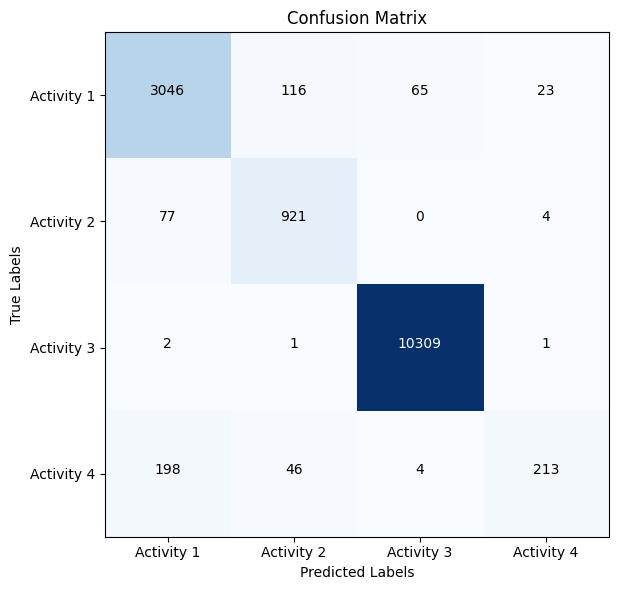

In [66]:
results_dict["Lasso + Poly KDA"] = eval_classifier(l_kda_poly, X_train=X_train_lasso, X_test=X_test_lasso)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.9801011579928125
Precision: 0.9794853561891314
Recall: 0.9801011579928125
F1-score: 0.9787195164066576
Confusion Matrix:


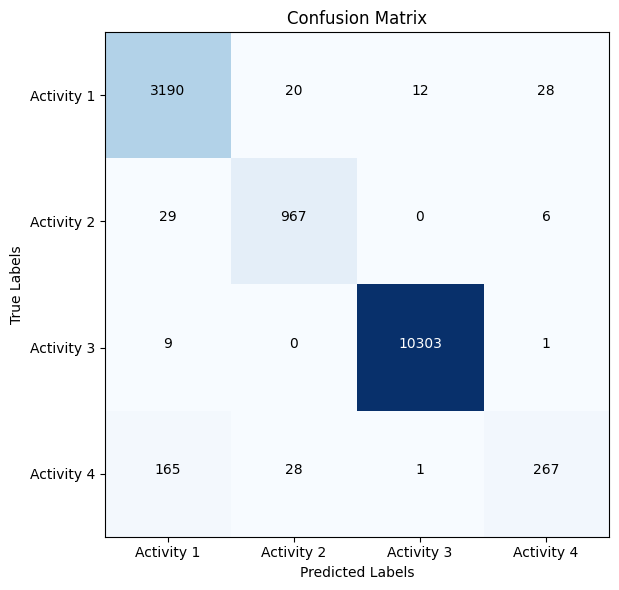

In [67]:
"""
5.3 Neural Network
Build a simple Neural Network using either MLPClassifier from scikit-learn or a Pytorch model. Train and evaluate it using:
The full feature set
PCA-reduced data
Feature-selected data
"""

#create mlp pipeline for training full dataset
mlp_full_dataset = make_pipeline(StandardScaler(), MLPClassifier(
    hidden_layer_sizes=(100,),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    learning_rate='adaptive',
    max_iter=200,
    random_state=42
))

#train and evaluate dataset
results_dict["MLP on Full Dataset"] = eval_classifier(mlp_full_dataset)


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.9560761346998536
Precision: 0.9562003334240355
Recall: 0.9560761346998536
F1-score: 0.9533460283026527
Confusion Matrix:


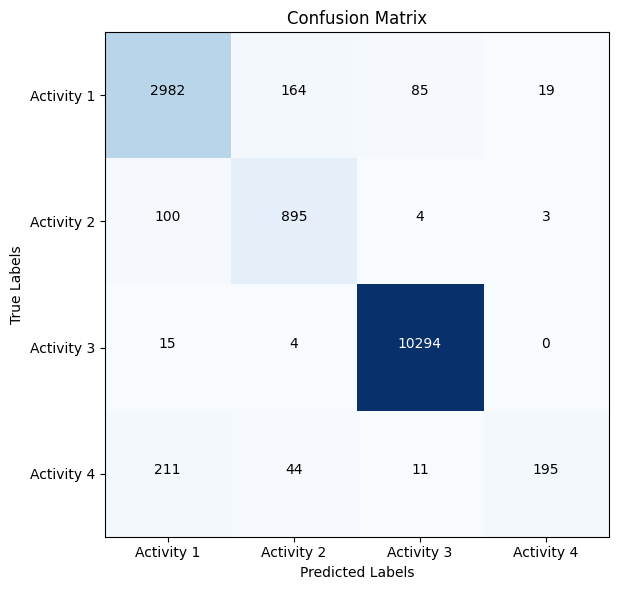

In [68]:
#create mlp pipeline for PCA reduced dataset
mlp_pca = make_pipeline(StandardScaler(), PCA(n_components=5), MLPClassifier(
    hidden_layer_sizes=(100,),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    learning_rate='adaptive',
    max_iter=200,
    random_state=42
))

#train and evaluate dataset
results_dict["MLP on PCA Reduced Dataset"] = eval_classifier(mlp_pca)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.9761746306402236
Precision: 0.9756739097084582
Recall: 0.9761746306402236
F1-score: 0.9743600350273316
Confusion Matrix:


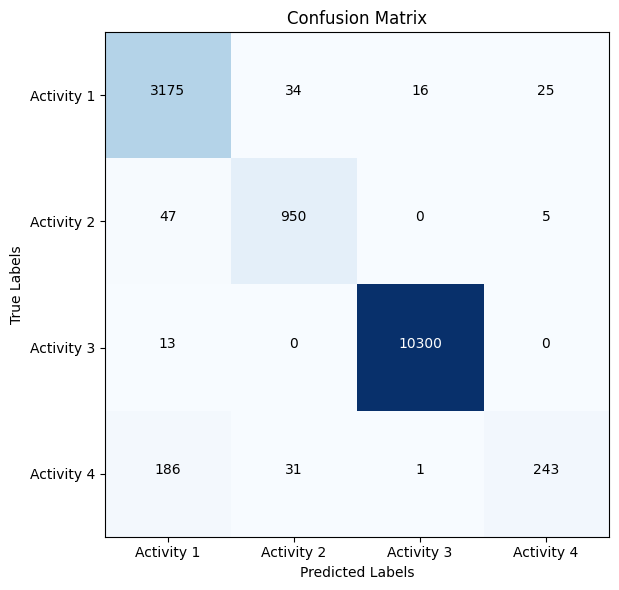

In [69]:
#create mlp pipeline for feature selected data


mlp_lasso = make_pipeline(StandardScaler(), SelectFromModel(Lasso(alpha=0.01)), MLPClassifier(
    hidden_layer_sizes=(100,),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    learning_rate='adaptive',
    max_iter=200,
    random_state=42
))

#train and evaluate dataset
results_dict["MLP on Lasso Reduced Dataset"] = eval_classifier(mlp_lasso)

Accuracy: 0.9581392253427392
Precision: 0.9522567080204387
Recall: 0.9581392253427392
F1-score: 0.9532806258457829
Confusion Matrix:


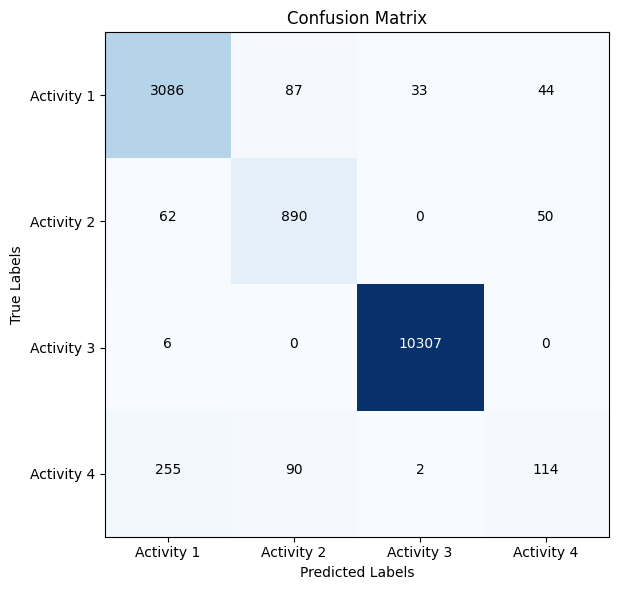

In [70]:
#create mlp pipeline for feature selected data


mlp_chi2 = make_pipeline(MinMaxScaler(), SelectKBest(chi2, k=5), MLPClassifier(
    hidden_layer_sizes=(100,),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    learning_rate='adaptive',
    max_iter=200,
    random_state=42
))

#train and evaluate dataset
results_dict["MLP on Chi2 Reduced Dataset"] = eval_classifier(mlp_chi2)

**Part 6: Performance Comparison**

**6.1 Create a Summary Table**
Summarize the performance of all methods using metrics:

* Accuracy

* Precision

* Recall

* F1-score

**6.2 Discussion**

* Compare classifiers’ performance across different feature spaces.

* Which feature selection method worked best?

* Was PCA beneficial?

* How did the Neural Network perform compared to other classifiers?

* Discuss the strengths and weaknesses of each approach.

In [71]:
"""
6.1 Create a Summary Table Summarize the performance of all methods using metrics:
Accuracy
Precision
Recall
F1-score
"""

#convert dictionary with results to pandas dataframe
df_metrics = pd.DataFrame(results_dict).T
df_metrics = df_metrics[['accuracy', 'precision', 'recall', 'f1']]

#style to make it easier to see high values
styled_df = (df_metrics.style
             .background_gradient(cmap='viridis')
             .highlight_max(axis=0, color="lightgreen")
)

#display table
styled_df


,accuracy,precision,recall,f1
SVM,0.972647,0.973498,0.972647,0.969786
RBF SVM,0.972647,0.973498,0.972647,0.969786
Poly SVM,0.971649,0.972030,0.971649,0.968934
KNN3,0.984227,0.984021,0.984227,0.983731
KNN5,0.982231,0.981955,0.982231,0.981565
KNN10,0.974045,0.973419,0.974045,0.972038
KNN2,0.984760,0.984835,0.984760,0.984164
Naive Bayes,0.939971,0.939746,0.939971,0.935411
LDA,0.909357,0.911266,0.909357,0.886885
RBF KDA,0.970784,0.969737,0.970784,0.969150


**6.2 Discussion**

* Compare classifiers’ performance across different feature spaces.

* Which feature selection method worked best?

* Was PCA beneficial?

* How did the Neural Network perform compared to other classifiers?

* Discuss the strengths and weaknesses of each approach.

Using chi2 feature selection with KNN3 had the best accuracy, precision, recall, and f1 score. While chi2 features selection had the best results using KNN3, most other classifiers performed better when using Lasso to reduce the data.

All classification methods did the worst when PCA reduction was applied, so PCA was not beneficial for this dataset.

The Nueral Network performed well compared to most other classifier methods, however K Nearest Neighbor performed better on the full dataset and when chi squared was used to reduce the data. When Lasso was used to reduce the data, the neural network did better.  

LDA was the worst classification method overall.

Reducing data can help to improve the speed of training for large datasets. Chi squared reduction is beneficial because it preserves statistical relationships in the data by identifying the relationships between features and removing features that are less related to the target. SVM is beneficial for removing irrelevant data. It may be more helpful in datasets with more features. PCA is beneficial to reduce the data with many features that are correlated to each other. It also is helpful when using linear classification methods like LDA. Mutual information is a good reduction method to use to capture nonlinear relationships. Lasso is beneficial when there are lots of features that may be irrelevant features.

LDA is a good classification method when data relationships are linear, but it fails for nonlinear data. KDA is better for capturing nonlinear class boundaries, however it takes longer to calculate for large datasets. Naive Bayes works well for categorical data that is not highly correlated. It does not perform as well when data is highly correlated. KNN works for many different types of data, however it can take a longer time to make predictions. ANN is also very flexible, but it requires a large amount of data to train successfully.  